In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
from util import figure_to_vdom_image, create_motif_similarity_matrix, purine_rich_motif
import h5py
import numpy as np
import sklearn.cluster
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


In [3]:
if "TFM_TF_NAME" in os.environ:
    tf_name = os.environ["TFM_TF_NAME"]
    if "TFM_TASK_INDEX" in os.environ:
        task_index = int(os.environ["TFM_TASK_INDEX"])
    else:
        task_index = None
else:
    tf_name = "MAX"
    task_index = 2

In [4]:
if task_index is None:
    out_path = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproduciblity/%s_fold_model_motif_reproducibility" % tf_name
else:
    out_path = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproduciblity/%s_task%d_fold_model_motif_reproducibility" % (tf_name, task_index)
os.makedirs(out_path, exist_ok=True)

tf_num_tasks = {
    "E2F6": 2,
    "FOXA2": 4,
    "SPI1": 4,
    "CEBPB": 7,
    "MAX": 7,
    "GABPA": 9,
    "MAFK": 9,
    "JUND": 14,
    "NR3C1-reddytime": 16,
    "REST": 20
}

tf_best_model_types = {
    "E2F6": list("MM"),
    "FOXA2": list("SSMM"),
    "SPI1": list("MSSS"),
    "CEBPB": list("MMMMSMM"),
    "MAX": list("MMSMMSS"),
    "GABPA": list("MMMSMMMMM"),
    "MAFK": list("MMMMMMMMM"),
    "JUND": list("SMMSMSSSSSSSMS"),
    "NR3C1-reddytime": list("MMMSMMSMMMMSMMMM"),
    "REST": list("MMMMMMMMMSMMSMMSMMMM")
}

num_tasks = tf_num_tasks[tf_name]
best_model_types = tf_best_model_types[tf_name]

seed = 20210910

motif_file = "/users/amtseng/tfmodisco/results/motifs/tfmodisco/%s_tfmodisco_motifs.h5" % tf_name

multitask_finetune_model_def_tsv = "/users/amtseng/tfmodisco/results/model_stats/multitask_profile_finetune_stats.tsv"
singletask_finetune_model_def_tsv = "/users/amtseng/tfmodisco/results/model_stats/singletask_profile_finetune_stats.tsv"

### Helper functions

In [5]:
sanitize_fold = lambda fold: "F" + fold.split("_")[1]
sanitize_task = lambda task: "T" + task.split("_")[1]

def import_all_tfmodisco_motifs(motif_file, task_index=None):
    """
    From a file containing all motifs for that TF, imports the
    trimmed CWMs of all conditions as a dictionary. Returns a dictionary
    of motifs, mapping a unique key to the trimmed CWM.
    If `task_index` is given, only import the single-task motifs and
    fine-tuned multi-task motifs for that task.
    """
    motifs = {}
    with h5py.File(motif_file, "r") as f:
        # Multi-task, all 10 folds
        if task_index is None:
            mt = f["multitask"]
            for fold in mt.keys():
                mt_fold = mt[fold]
                for key in ("count", "profile"):
                    mt_fold_key = mt_fold[key]
                    for motif_key in mt_fold_key.keys():
                        if motif_key.startswith("0_"):
                            # Positive metacluster only
                            name = "MT:%s:%s:%s" % (sanitize_fold(fold), key[0].upper(), motif_key)
                            motifs[name] = purine_rich_motif(mt_fold_key[motif_key]["cwm_trimmed"][:])
        
        # Single-task, all 10 folds for all tasks or just a single task
        st = f["singletask"]
        for task in (st.keys() if task_index is None else ["task_%d" % task_index]):
            st_task = st[task]
            for fold in st_task.keys():
                st_task_fold = st_task[fold]
                for key in ("count", "profile"):
                    st_task_fold_key = st_task_fold[key]
                    for motif_key in st_task_fold_key.keys():
                        if motif_key.startswith("0_"):
                            # Positive metacluster only
                            name = "ST:%s:%s:%s:%s" % (sanitize_task(task), sanitize_fold(fold), key[0].upper(), motif_key)
                            motifs[name] = purine_rich_motif(st_task_fold_key[motif_key]["cwm_trimmed"][:])
        
        # Multi-task fine-tune, all tasks plus aggregate task or just a single task
        mtft = f["multitask_finetune"]
        for task in (mtft.keys() if task_index is None else ["task_%d" % task_index]):
            mtft_task = mtft[task]
            for key in ("count", "profile"):
                mtft_task_key = mtft_task[key]
                for motif_key in mtft_task_key.keys():
                    if motif_key.startswith("0_"):
                        # Positive metacluster only
                        name = "MTFT:%s:%s:%s" % (sanitize_task(task), key[0].upper(), motif_key)
                        motifs[name] = purine_rich_motif(mtft_task_key[motif_key]["cwm_trimmed"][:])
        
        # Single-task fine-tune, all tasks or just a single task
        stft = f["singletask_finetune"]
        for task in (stft.keys() if task_index is None else ["task_%d" % task_index]):
            stft_task = stft[task]
            for key in ("count", "profile"):
                stft_task_key = stft_task[key]
                for motif_key in stft_task_key.keys():
                    if motif_key.startswith("0_"):
                        # Positive metacluster only
                        name = "STFT:%s:%s:%s" % (sanitize_task(task), key[0].upper(), motif_key)
                        motifs[name] = purine_rich_motif(stft_task_key[motif_key]["cwm_trimmed"][:])
        
    return motifs

In [6]:
def get_num_seqlets(motif_key):
    """
    Fetches the number of seqlets initially mapped to the given motif from the
    original TF-MoDISco file.
    """
    base_path = "/users/amtseng/tfmodisco/results/tfmodisco"
    cond_type = motif_key.split(":")[0]
    if cond_type == "MTFT":
        # Get best fold
        best_mt_fold = None
        with open(multitask_finetune_model_def_tsv, "r") as f:
            for line in f:
                tokens = line.strip().split("\t")
                if tokens[0] == tf_name and int(tokens[1]) == num_tasks - 1:
                    assert best_mt_fold is None
                    best_mt_fold = int(tokens[2])
        task, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "multitask_profile_finetune",
            "%s_multitask_profile_finetune_fold%d" % (tf_name, best_mt_fold)
        )
        if task == "agg":
            path = os.path.join(
                path,
                "%s_multitask_profile_finetune_fold%d_%s_tfm.h5" % (tf_name, best_mt_fold, head)
            )
        else:
            path = os.path.join(
                path,
                "%s_multitask_profile_finetune_task%s_fold%d_%s_tfm.h5" % (tf_name, task, best_mt_fold, head)
            )
    elif cond_type == "STFT":
        # Get best fold
        best_st_folds = []
        with open(singletask_finetune_model_def_tsv, "r") as f:
            for line in f:
                tokens = line.strip().split("\t")
                if tokens[0] == tf_name:
                    best_st_folds.append(int(tokens[2]))
        assert len(best_st_folds) == num_tasks
        task, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        head = "profile" if head == "P" else "count"
        best_st_fold = best_st_folds[int(task)]
        path = os.path.join(
            base_path,
            "singletask_profile_finetune",
            "%s_singletask_profile_finetune_fold%d" % (tf_name, best_st_fold),
            "task_%s" % task,
            "%s_singletask_profile_finetune_task%s_fold%d_%s_tfm.h5" % (tf_name, task, best_st_fold, head)
        )        
    elif cond_type == "MT":
        fold, head, pattern = motif_key.split(":")[1:]
        fold = fold[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "multitask_profile",
            "%s_multitask_profile_fold%s" % (tf_name, fold),
            "%s_multitask_profile_fold%s_%s_tfm.h5" % (tf_name, fold, head)
        )
    elif cond_type == "ST":
        task, fold, head, pattern = motif_key.split(":")[1:]
        task = task[1:]
        fold = fold[1:]
        head = "profile" if head == "P" else "count"
        path = os.path.join(
            base_path,
            "singletask_profile",
            "%s_singletask_profile_fold%s" % (tf_name, fold),
            "task_%s" % task,
            "%s_singletask_profile_task%s_fold%s_%s_tfm.h5" % (tf_name, task, fold, head)
        )
    else:
        raise ValueError("Unknown model condition type")
        
    # Now that we have the path, import the number of seqlets for the given pattern
    metacluster_key, pattern_key = pattern.split("_")
    with h5py.File(path, "r") as f:
        metacluster = f["metacluster_idx_to_submetacluster_results"]["metacluster_%s" % metacluster_key]
        patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
        seqlets = patterns["pattern_%s" % pattern_key]["seqlets_and_alnmts"]["seqlets"]
        return len(seqlets)

In [7]:
def make_cdf(ax, data, steps=1000, density=False, inverse=False, **kwargs):
    """
    Plots a CDF to the given axes. `steps` is the number of steps in the
    CDF. If `inverse` is True, plots an inverse CDF (AKA survivorship plot).
    `density` is whether or not to normalize to fractions.
    """
    hist, bin_edges = np.histogram(data, bins=steps)
    if inverse:
        cumsum = len(data) - np.cumsum(hist)
    else:
        cumsum = np.cumsum(hist)
    if density:
        cumsum = cumsum / len(data)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    ax.step(bin_centers, cumsum, **kwargs)

In [8]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Order cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = np.argsort(-np.mean(kmeans_centers, axis=1))

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds, cluster_assignments[cluster_inds]

In [9]:
def plot_motif_examples(motif_keys, motifs, cond_names, cond_inds):
    """
    Creates a table of motifs. The full set of motifs and keys
    are given, and `cond_names` and `cond_inds` are parallel lists
    containing conditions and a list of indices to plot for each.
    A pair of columns is created for each condition.
    """
    assert len(cond_names) == len(cond_inds)
    cols = []
    heads = []
    for i in range(len(cond_names)):
        cols.append(vdomh.col(style={"width": str(10 / len(cond_inds)) + "%"}))
        cols.append(vdomh.col(style={"width": str(90 / len(cond_inds)) + "%"}))
        heads.append(vdomh.th("Motif ID", style={"text-align": "center"}))
        heads.append(vdomh.th("Motif (%s)" % cond_names[i], style={"text-align": "center"}))
    colgroup = vdomh.colgroup(*cols)
    header = vdomh.thead(vdomh.tr(*heads))

    max_length = max([len(inds) for inds in cond_inds])
    rows = []
    for row_i in range(max_length):
        row = []
        for col_i in range(len(cond_names)):
            if row_i < len(cond_inds[col_i]):
                motif_i = cond_inds[col_i][row_i]
                fig = viz_sequence.plot_weights(
                    motifs[motif_i], subticks_frequency=100, figsize=(20, 4), return_fig=True
                )
                fig.tight_layout()
                row.extend([
                    vdomh.td(motif_keys[motif_i]),
                    vdomh.td(figure_to_vdom_image(fig))
                ])
            else:
                row.extend([vdomh.td(), vdomh.td()])
        rows.append(vdomh.tr(*row))
    display(vdomh.table(colgroup, header, vdomh.tbody(*rows)))
    plt.close("all")

### Import motifs and construct similarity matrix

In [10]:
motif_keys, motifs = zip(*import_all_tfmodisco_motifs(motif_file, task_index).items())
motif_keys, motifs = list(motif_keys), list(motifs)

In [11]:
raw_sim_matrix = create_motif_similarity_matrix(motifs, mean_normalize=False)

  0%|          | 0/97 [00:00<?, ?it/s]

In [12]:
# Extract the number of seqlest for each motif
motif_num_seqlets = np.array([
    get_num_seqlets(key) for key in tqdm.notebook.tqdm(motif_keys)
])

  0%|          | 0/97 [00:00<?, ?it/s]

### Plot similarity of each motif to closest motif in each condition

In [13]:
# First, create a dictionary mapping each condition to the column indices
cond_inds = {}
for i, key in enumerate(motif_keys):
    cond_key = ":".join(key.split(":")[:-2])  # Strip off last two pieces
    try:
        cond_inds[cond_key].append(i)
    except KeyError:
        cond_inds[cond_key] = [i]
for key in list(cond_inds.keys()):
    cond_inds[key] = np.array(cond_inds[key])

In [14]:
# Normalize the number of seqlets over each condition separately
motif_prop_seqlets = np.empty(len(motif_num_seqlets))
for inds in cond_inds.values():
    motif_prop_seqlets[inds] = motif_num_seqlets[inds] / np.sum(motif_num_seqlets[inds])

In [15]:
# Construct a limited version of the similarity matrix, where the columns
# are the highest similarity over the entire condition
cond_sim_matrix = np.empty((len(motif_keys), len(cond_inds)))
for i, cond_key in enumerate(cond_inds.keys()):
    cond_sim_matrix[:, i] = np.max(raw_sim_matrix[:, cond_inds[cond_key]], axis=1)

In [16]:
# Order similarity matrix rows by optimal cluster order
order_inds, cluster_ids = cluster_matrix_indices(
    cond_sim_matrix,
    max([len(inds) for inds in cond_inds.values()])
    # Maximum number of clusters should be biggest condition size
)
cond_sim_matrix = cond_sim_matrix[order_inds]

# Order motif keys and motifs
sorted_motif_keys = [motif_keys[i] for i in order_inds]
sorted_motifs = [motifs[i] for i in order_inds]
sorted_motif_prop_seqlets = np.array([motif_prop_seqlets[i] for i in order_inds])

# Sort each matrix row independently, most to least similar
cond_sim_matrix = -np.sort(-cond_sim_matrix, axis=1)  # Negatives make it sort descending

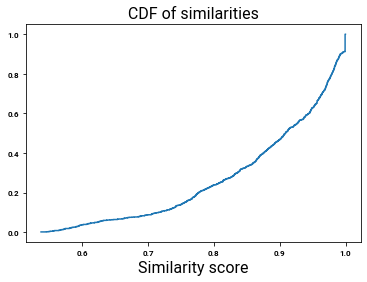

In [17]:
fig, ax = plt.subplots()
make_cdf(ax, np.ravel(cond_sim_matrix), density=True)
ax.set_title("CDF of similarities")
ax.set_xlabel("Similarity score")
plt.show()

# # Normalize the matrix entries to percentile
# cond_sim_matrix_perc = scipy.stats.rankdata(cond_sim_matrix).reshape(cond_sim_matrix.shape) / cond_sim_matrix.size

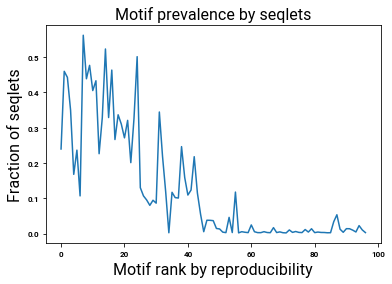

In [18]:
fig, ax = plt.subplots()
ax.set_title("Motif prevalence by seqlets")
ax.set_xlabel("Motif rank by reproducibility")
ax.set_ylabel("Fraction of seqlets")
ax.plot(sorted_motif_prop_seqlets)
plt.show()

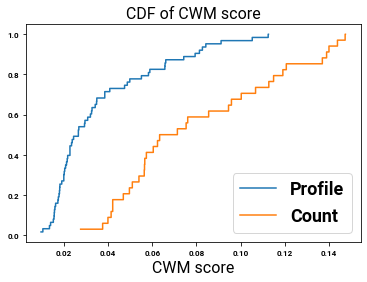

In [19]:
# Extract the CWM score of each motif in order
sorted_motif_scores = np.array([np.max(cwm) for cwm in sorted_motifs])

# Separate out profile and count CWMs
profile_inds = np.array([i for i in range(len(sorted_motif_keys)) if sorted_motif_keys[i].split(":")[-2] == "P"])
count_inds = np.array([i for i in range(len(sorted_motif_keys)) if sorted_motif_keys[i].split(":")[-2] == "C"])

fig, ax = plt.subplots()
make_cdf(ax, sorted_motif_scores[profile_inds], density=True, label="Profile")
make_cdf(ax, sorted_motif_scores[count_inds], density=True, label="Count")
ax.set_title("CDF of CWM score")
ax.set_xlabel("CWM score")
plt.legend()
plt.show()

# Normalize the CWM scores to map to percentile (i.e. map CDF x-axis to y-axis)
# Do counts/profile CWMs separately
sorted_motif_score_percs = np.empty_like(sorted_motif_scores)
sorted_motif_score_percs[profile_inds] = scipy.stats.rankdata(sorted_motif_scores[profile_inds]) / len(profile_inds)
sorted_motif_score_percs[count_inds] = scipy.stats.rankdata(sorted_motif_scores[count_inds]) / len(count_inds)

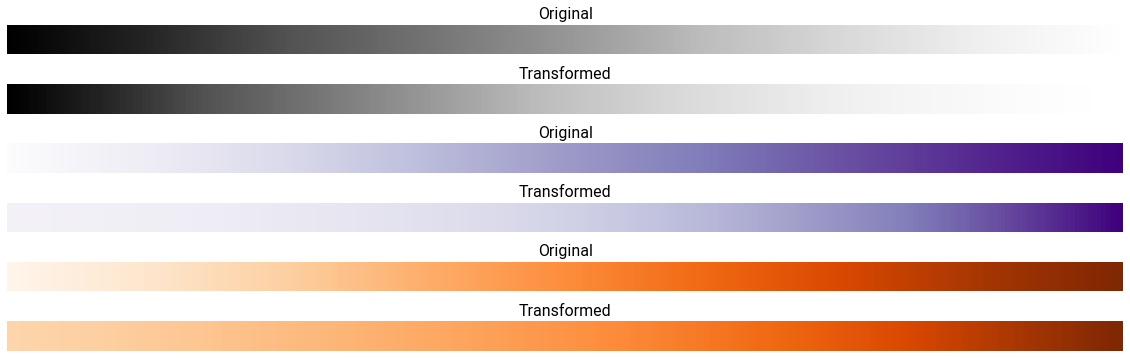

In [20]:
# Create good non-uniform color maps for the data
sim_decay_scale = 1.5
score_decay_scale = 2.5
seq_decay_scale = 1.5

x = np.linspace(0, 1, 256)

transformed = np.power(np.flip(x), sim_decay_scale)
sim_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "sim_cmap", plt.get_cmap("Greys")(transformed)
)

transformed = np.exp(score_decay_scale * x) / np.exp(score_decay_scale)
score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "sim_cmap", plt.get_cmap("Purples")(transformed)
)

transformed = np.exp(seq_decay_scale * x) / np.exp(seq_decay_scale)
seq_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "sim_cmap", plt.get_cmap("Oranges")(transformed)
)

# Show the color map with the original
fig, ax = plt.subplots(nrows=6, figsize=(20, 6), gridspec_kw={"hspace": 1})
grad = np.linspace(0, 1, 256)
ax[0].imshow(grad[None, :], aspect="auto", cmap="Greys_r")
ax[1].imshow(grad[None, :], aspect="auto", cmap=sim_cmap)
ax[2].imshow(grad[None, :], aspect="auto", cmap="Purples")
ax[3].imshow(grad[None, :], aspect="auto", cmap=score_cmap)
ax[4].imshow(grad[None, :], aspect="auto", cmap="Oranges")
ax[5].imshow(grad[None, :], aspect="auto", cmap=seq_cmap)
for i in range(6):
    ax[i].axis("off")
    if i % 2 == 0:
        ax[i].set_title("Original")
    else:
        ax[i].set_title("Transformed")
plt.show()

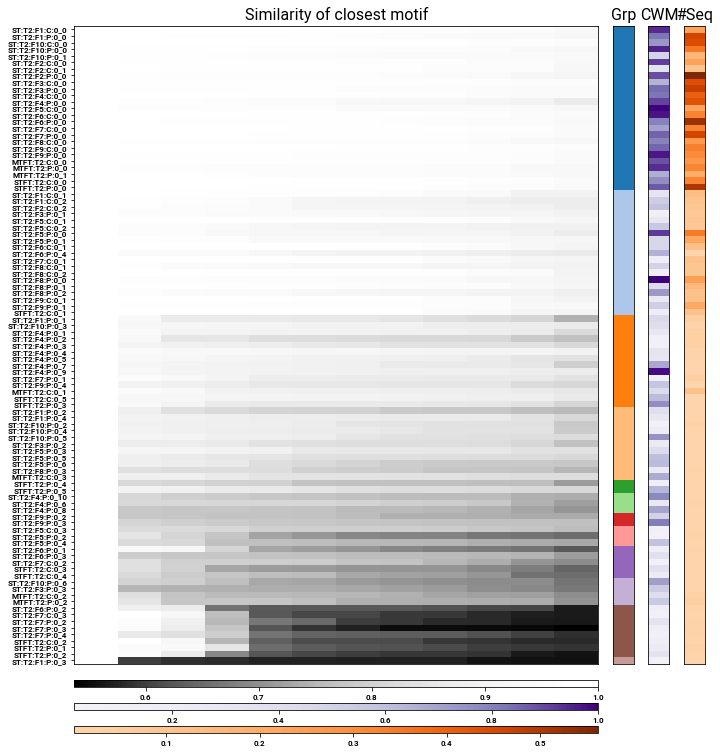

In [21]:
grid_height = max(5, len(motif_keys) * 0.1)
grid_width = max(5, len(cond_inds) * 0.1)
height_spacing, width_spacing = 0.1, 0.1
height = grid_height + 3 + (height_spacing * 3)
width = grid_width + 6 + (width_spacing * 3)

fig, ax = plt.subplots(
    nrows=4, ncols=4, figsize=(width, height),
    gridspec_kw={
        "height_ratios": [grid_height / 0.1, 1, 1, 1],
        "width_ratios": [grid_width / 0.1, 2, 2, 2],
        "hspace": height_spacing,
        "wspace": width_spacing
    }
)

sim_hmap = ax[0, 0].imshow(cond_sim_matrix, cmap=sim_cmap, aspect="auto")  # auto aspect to stretch
score_hmap = ax[0, 2].imshow(sorted_motif_score_percs[:, None], cmap=score_cmap, aspect="auto")
seq_hmap = ax[0, 3].imshow(sorted_motif_prop_seqlets[:, None], cmap=seq_cmap, aspect="auto")

# Cluster IDs may not be in order, so sort the groups
diffs = np.concatenate([[0], np.diff(cluster_ids)])
diffs[diffs != 0] = 1
reordered_cluster_ids = np.cumsum(diffs)

cmap = cm.get_cmap("tab20")
group_colors = cmap(reordered_cluster_ids[:, None] % 20 / 20)[:, :, :3]
ax[0, 1].imshow(group_colors, aspect="auto")
# we need to first translate into colors instead of specifying `cmap=` to `imshow`,
# otherwise the colors will be different

ax[0, 0].set_yticks(np.arange(len(motif_keys)))
ax[0, 0].set_yticklabels(sorted_motif_keys)
ax[0, 0].set_xticks([])
ax[0, 0].set_title("Similarity of closest motif")
ax[0, 1].set_title("Grp")
ax[0, 2].set_title("CWM")
ax[0, 3].set_title("#Seq")

for i in range(1, 4):
    ax[0, i].set_yticks([])
    ax[0, i].set_xticks([])
    for j in range(1, 4):
        ax[j, i].axis("off")
        ax[j, i].axis("off")
        ax[j, i].axis("off")

fig.colorbar(sim_hmap, cax=ax[1, 0], orientation="horizontal")
fig.colorbar(score_hmap, cax=ax[2, 0], orientation="horizontal")
fig.colorbar(seq_hmap, cax=ax[3, 0], orientation="horizontal")

plt.savefig(
    os.path.join(out_path, "%s_fold_model_motif_reproducibility.svg" % tf_name),
    format="svg"
)
plt.show()

In [22]:
# Show the average similarity of each cluster, and overall
cmap = cm.get_cmap("tab20")

colgroup = vdomh.colgroup(
    vdomh.col(style={"width": "10%"}),
    vdomh.col(style={"width": "10%"}),
    vdomh.col(style={"width": "10%"}),
    vdomh.col(style={"width": "10%"}),
    vdomh.col(style={"width": "10%"})
)
header = vdomh.thead(vdomh.tr(
    vdomh.th("Cluster ID", style={"text-align": "center"}),
    vdomh.th("Cluster color", style={"text-align": "center"}),
    vdomh.th("Number of motifs", style={"text-align": "center"}),
    vdomh.th("Mean similarity", style={"text-align": "center"}),
    vdomh.th("Standard error", style={"text-align": "center"})
))

rows = []
for cluster_id in np.unique(reordered_cluster_ids):
    match_inds = np.where(reordered_cluster_ids == cluster_id)[0]
    
    sims = cond_sim_matrix[match_inds][:, 1:]  # First column is always 1, so remove it
    
    mean, stderr = np.mean(sims), np.std(sims) / np.sqrt(sims.size)
        
    group_color = matplotlib.colors.rgb2hex(cmap(cluster_id % 20 / 20))
    fig, ax = plt.subplots(figsize=(0.3, 0.3))
    circle = plt.Circle((0, 0), 10, color=group_color)
    ax.add_patch(circle)
    ax.axis("off")
    plt.axis("scaled")
    
    rows.append(vdomh.tr(
        vdomh.td(str(cluster_id)),
        vdomh.td(figure_to_vdom_image(fig)),
        vdomh.td(str(len(match_inds))),
        vdomh.td(str(mean)),
        vdomh.td(str(stderr))
    ))

total_sims = cond_sim_matrix[:, 1:]
total_mean, total_stderr = np.mean(total_sims), np.std(total_sims) / np.sqrt(total_sims.size)
rows.append(vdomh.tr(
    vdomh.td("All"),
    vdomh.td(""),
    vdomh.td(str(len(total_sims))),
    vdomh.td(str(total_mean)),
    vdomh.td(str(total_stderr))
))

display(vdomh.table(colgroup, header, vdomh.tbody(*rows)))
plt.close("all")

<table><colgroup><col style="width: 10%"></col><col style="width: 10%"></col><col style="width: 10%"></col><col style="width: 10%"></col><col style="width: 10%"></col></colgroup><thead><tr><th style="text-align: center">Cluster ID</th><th style="text-align: center">Cluster color</th><th style="text-align: center">Number of motifs</th><th style="text-align: center">Mean similarity</th><th style="text-align: center">Standard error</th></tr></thead><tbody><tr><td>0</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAVCAYAAACpF6WWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAABRklEQVR4nLXUMUscQRgG4OdUEAxCChu7VfwN6W0ssq2CWIkgWKiFjVsF7bYTTJ0gVoKV4P6DNAHB3mpBBAsLvaAopzmLW2HV2fPu1LfbGeaZ7xtmp9ZsNn10%2Bj5cxEC7ySjJapjEEsaKIs7wG4d5Gt%2BH1tWq2o%2BSbBpb%2BIovqJWm/6GBTfzM0/gZEkSjJFvHDwy16wTX2MNiGX51plGSzXUIKjqYxUZlpVGS9eMcIx2A5dxiNE/jy1Cl3zHYJQj/Mf/08RJdwXAP6BBWq9DxHsCnjFahbe/tG%2BmvQi/egdar0B2tu9dtGlr3NYjuBsY6yT22g2iexnX8wk0X4C3%2B5Gl8EkSLrOGoQ/gOp5gpD75C8zRuYAoHRRWNAPZQbPoX3/I0vipPVr5SECXZBJaxoPWfN4tN9rGVp/FxaF1btNd8ysv/KegjqSFbZpkkgu0AAAAASUVORK5CYII%3D"></img></div></td><td>25</td><td>0.9683034499873129</td><td>0.0011628138620344967</td></tr><tr><td>1</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAVCAYAAACpF6WWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAABS0lEQVR4nLXUsUsbURwH8E%2BMUEgROghHxop/Q7nVxaHbgYXSqQiFDraDSzfRvyCgsyJOgsNR6J/Q4QqF7l2L0IMO1aJEEo1DLnBt3qVJTL7bvcf7vN/v8e7Ver2eWWdh5iIWR02mWV7DGt7iaVHEOY7wKYmjbmhdrar9NMs30MITPEatNP0HHezhIImjv5Agmmb5B%2BygMaoTXOEUb8rw0JmmWf5qTFDRwUvsVlaaZnkdP7E8BlhOG80kjn6HKn2ORxOCcIfXg49/0XdYmgJt4H0VujIFOEizCh15b/%2BTehX66wHoZRV6rH/3Jk1H/74G0ZPA2DjpYj%2BIJnF0iUNcTwC28TmJo%2B9BtMg2vo4J3%2BAHXpQHh9AkjjpYx8eiik4Auy02/YJnSRxdlCcrXylIs3wVW9jU/897xSZnaCVx9C20biQ6beby8s8FvQdn41gtJJTMkwAAAABJRU5ErkJggg%3D%3D"></img></div></td><td>19</td><td>0.9452987988278844</td><td>0.002368546120464705</td></tr><tr><td>2</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAVCAYAAACpF6WWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAABLklEQVR4nLXUsStFURwH8M9DKdI1WIzkb7BbDGZKJillwGCx6fgLFDPJpEzKn2BRym6VMhgcInp4hnfVxbm39x6%2B2z2n8zm/3%2B2cU2s0Gv46XX8uoqdyNmQ1TGAJI3kR19jDiRBfU8tqpe2HbBpbGEQ/aoXZB9SxiR0hfkHSaMjWsYG%2Byk54xCEWi/DPfxqyuRZBeQezCOWVhqwbNxhqASzmGcNCvEtVOoXeNkF4x/znx3d0BQMdoH1YLUNHOwA/M1yGVp/b6nSXobe/QO/L0H3Ns9du6prnNYkeJMZaySu202iI99jFUxvgM06FeJlGm1nDeYvwC64wUxxMXNNYxySO8yrqCewt3/QM40KMxcnyVwpCNoZlLGje80a%2ByRG2hHiRWlaNdph/efn/Bf0ATwhUoF7RYp8AAAAASUVORK5CYII%3D"></img></div></td><td>14</td><td>0.878254353928954</td><td>0.002943097683681809</td></tr><tr><td>3</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAVCAYAAACpF6WWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAABNElEQVR4nLXUvytFYRgH8M91lSJlsBjJ32BXJ4OZkklKGTBYdBYxnVExk0zKpIxntChlt0oZDH5EVxfXcI86eM/p3ovvdt639/M%2Bz9t73kqj0fDX6fpzEd2ls2lcwTgWMZwVcY09nIiS19CySmH7aTyFLQygD5Xc7CPq2MSOKPmChNE0XsM6eks74QmHWMjDP880jWdbBGUdzGCjuNI0ruIGgy2A%2BdQwJEruQpVOoqdNEN4x9/nxHV1GfwdoL1aK0JEOwM8MFaHl97Y81SL09hfoQxG6r3n32k1d874G0YPAWCt5xXYYjZIH7OK5DbCGU1FyGUabWcV5i/ALrjCdH/yJRkkdEzjOqqgHsLds0zOMiZL7/GTxKwVpPIolzGv%2B541skyNsiZKL0LJytMP8y8v/L%2BgHjvtSrqapbO8AAAAASUVORK5CYII%3D"></img></div></td><td>11</td><td>0.8416124505431479</td><td>0.0034011274635520204</td></tr><tr><td>4</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABUAAAAVCAYAAACpF6WWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAABRUlEQVR4nLXUsUtbQRwH8E%2BaQiEidOiSUel6q7uLQ%2BcWpMsrguC

<h3>Cluster 0 (25 motifs)</h3>

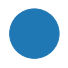

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>MTFT:T2:P:0_0</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAACHFklEQVR4nO3dd5xcdb3/8deZujtbUzYdkkBCQhEEooCAFBEFKSJS7N3f9V6vei3YvdZrL4AggggoIKKIgnSQLi2QhBYSQnrZZDfbd3bqOb8/vnN2ZjfZNufMzpb3M4/zmNnZOd/z3cnszvd8zuf7%2BVqO4yAiIiIiIiIiIiIi4rdAuTsgIiIiIiIiIiIiIhOTAtAiIiIiIiIiIiIiUhIKQIuIiIiIiIiIiIhISSgALSIiIiIiIiIiIiIloQC0iIiIiIiIiIiIiJSEAtAiIiIiIiIiIiIiUhIKQIuIiIiIiIiIiIhISSgALSIiIiIiIiIiIiIloQC0iIiIiIiIiIiIiJSEAtAiIiIiIiIiIiIiUhKhcndgMNOnT3cWLFhQ7m6IiIiIiIiIiIiISM6zzz7b7DhOw3CeO6YD0AsWLGD58uXl7oaIiIiIiIiIiIiI5FiWtWm4z1UJDhEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESkIBaBEREREREREREREpCQWgRURERERERERERKQkFIAWERERERERERERkZJQAFpERERERERERERESiJU7g6IiIjI8Ng2bNkCq1fDyy/D8uWwaRMkEpBMQjAIFRVQWwuHHw6HHgoHHQRLl0IsVu7ei4iIiIiIyGSkALSIiMgYtn073HILXHstvPgihEIQDkNPD6RSA%2B/3wANQVQWBAMTjMHUqnH02vO99cNxxJlgtIiIiIiIiUmqW4zjl7sOAli1b5ixfvrzc3RARERlV27bBzTfDNdfA2rUmWByPe283EDBBaYB3vQve/344%2BWTzuIiIiIiIiMhwWZb1rOM4y4bzXGVAi4iIjBGbNsG3vmWCz5Zlspz9ZNvQ2Wnu/%2BEP8Le/mczon/4Uzj1XgWgRERERERHxn041RUREymzTJvjgB02t5j/9ydR09jv43J/jmGD0pk3w0Y/CfvvBX/5igtQiIiIiIiIifvEcgLYsa4FlWSssy9poWdYVgz1uWdZ/WZa11bKsTZZlvcvrsUVERMazri74xCdM4Pmmm0zgOZ0uTz/cQPT%2B%2B8Mjj4x%2BH0RERERERGRi8iMD%2Bj%2BBh4ADgAsty1oyyOMfAr4MXA2c78OxRURExqVHHoHFi%2BH668sXeO6vqws2boS3vx0%2B/enSZ2GLiIiIiIjIxOdHALoB2O04TgpoA6YP8vifMMHn/83d34NlWZ%2B0LGu5ZVnLm5qafOieiIjI2NHTY4K7b387NDaa4PNY09MDv/%2B9ycx%2B5ply90ZERERERETGMz8C0M3ADMuyQkAdsHOQx78KvA34BCYTeg%2BO41zpOM4yx3GWNTQ0%2BNA9ERGRsWHlShPU/f3vx352cU8PbN4MJ5wAX/0qZLPl7pGIiIiIiIiMRyEf2vgNcAuwBrgB%2BKxlWb/v/7jjOOssy7oy9xwb%2BIEPxxYRERkX7rgDzj8f4vFy92RkenrgkktgxQq49VaorCx3j0QmCMeB7g3Q/gp0roGWFdD2PMQ3QzYJThocIBAEKwIVM6DuIJh6JNQdCDVLoHYpBCPl/klERERERAZlOY5T7j4MaNmyZc7y5cvL3Q0RERFPfvMb%2BMIXxn7W82AqKkzN6gceAE1QEimSnYGmx2DzzbD5L5DphkAEsgmwk8NrwwpCMGbuOxmYdQoseB/MOQ3CtaXru4iIiIhIAcuynnUcZ9lwnutHBrSIiIjshW3DRReZAPR4Dj6DqVX9yivw%2BtfDww/DokXl7pHIONL0OLxyMey4EwhANg5Orq5NdoR/HJwsZDrzX2%2B7HXY%2BZALYU5fB4v%2BA%2BRdCIOxX70VEREREPPGjBrSIiIj0k07DeeeZ4PN4K7sxkHTaLJy4bBk8/XS5eyMyxjkObL8L7joC/nUqbMllPGc688Fnv2Q6wU5B87/hmf%2BEW%2BfAmkshM86vfImIiIjIhKAAtIiIiM9sG973Prj77okTfHbZNrS3wymnlLsnImOUnYVNN8PtB8Bj50HrCpPxPFoyXZBshpVfhVtnwQvfh1T76B1fRERERKQfBaBFRER89rnPwZ13Trzgc6GurnL3QGQMan8Z7jocnvoodK0zGc/lku2GdAe8/H/wjwWw5W/l64uIiIiITGoKQIuIiPjohz%2BEq6%2BG7jLGnUbDGF7DWGT0ZVOw6ptw9zJof7G8gef%2Bsj2QboN/fwAePA16dpS7RyIiIiIyySgALSIi4pPf/x6%2B//2JnfksIv00Pw3/XAqv/CK3oOAYvTqTjUPjA6Y0yLrf6SqSiIiIiIwaBaBFRER8cPfd8OlPK/gsMmk4Drz8M3jgROjeMLp1novlpE2N6Gc/Bw%2B9Y2xlaouIiIjIhKUAtIiIiEdbt8IFF0BPT7l7IiKjIpuCJz4IL3w7l/U8zmS7YeeDcNcREN9a7t6IiIiIyASnALSIiIgHmQycdZYyn0UmjUQz3HcsbLnFBHLHKzsBXa/BHYdC81Pl7o2IiIiITGAKQIuIiHjwta/BmjUmEC0iE1z7y3Dn66D1%2BfGZ%2Bdyfk4V0KzxwMmy4ody9EREREZEJKlTuDoiIiIxX990Hv/61Sm%2BITAptL5nM53QHY3ahwWJl4/D0JyGbgEUfK3dvRERERGSCUQa0iIhIERob4bzzFHwWmRQ6XoX7j5%2BYwWdXNg7P/ne5eyEiIiIiE5AC0CIiIkX4wAegexyXfxWRYeraCPe9CVJtTNjgs2silBURERERkTFHAWgREZERuvVWeOIJ1X0WmfDi2%2BDeYyDVwoQPPouIiIiIlIgC0CIiIiPQ0QEf/7iyn0UmvFQb3PsmSDaBY5e7NyIiIiIi45YWIRQRERmBr3wF4vHy9iEQgIUL4aCD4MADYeZMiMVMRnZHB7z6KqxebbaOjvL2VWRccmx49F2QaAQnW%2B7eiIiIiIiMawpAi4iIDNNLL8G110IiMfrHnjoVzj4bPvpReOMbIZWCbBYqKyESyT/Ptk2A3P1eSwv86U9me%2BaZ0e%2B3y

<h3>Cluster 1 (19 motifs)</h3>

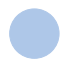

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F6:P:0_4</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAADlEUlEQVR4nOzdd5hjZfn/8fdJmV62985WWFjK0jsKiCAKKgIqlq8iYMHe/drr1/ZTFLuioghI770tdXdhe%2B91dmfLlExJO78/7mSn5GQmmUkyZT%2Bv68q1OyfJyZOZlOfc537u23FdFxERERERERERERGRXPP19QBEREREREREREREZHBSAFpERERERERERERE8kIBaBERERERERERERHJCwWgRURERERERERERCQvFIAWERERERERERERkbxQAFpERERERERERERE8kIBaBERERERERERERHJCwWgRURERERERERERCQvFIAWERERERERERERkbxQAFpERERERERERERE8iLQ1wNIGjFihDtlypS%2BHoaIiIiIiIiIiIiIdGHRokW1ruuOzOS2/SYAPWXKFBYuXNjXwxARERERERERERGRLjiOsyXT26oEh4iIiIiIiIiIiIjkhQLQIiIiIiIiIiIiIpIXCkCLiIiIiIiIiIiISF4oAC0iIiIiIiIiIiIieaEAtIiIiIiIiIiIiIjkhQLQIiIiIiIiIiIiIpIXCkCLiIiIiIiIiIiISF4oAC0iIiIiIiIiIiIieaEAtIiIiIiIiIiIiIjkhQLQIiIiIiIiIiIiIpIXCkCLiIiIiIiIiIiISF4oAC0iIiIiIiIiIiIieZFVANpxnCmO47zuOM5mx3F%2Bl8H2OY7jNDmO875cDlpERERERERERERE%2Br9sM6BvAJ4BZgJXOo4zK912x3GKgD8De3IzVBEREREREREREREZSLINQI8E9rmuGwYOAiO62P4j4B/A5nQ7cxznWsdxFjqOs3Dv3r1ZDkVERERERERERERE%2BrNAlrevBUY5jhMAqoGaNNujwPuA/cAkLDP6n5135rruH4A/AMyfP9/tyRMQERERERERERERkf4p2wzom4EzgTXArcCNjuMc13m767qvuK47ynXd2cCrwBdzOGYRERERERERERERGQCyyoB2XXcjcFyaqz23u657TpZjEhEREREREREREZFBINsMaBERERERERERERGRjCgALSIiIiIiIiIiIiJ5oQC0iIiIiIiIiIiIiOSFAtAiIiIiIiIiIiIikhcKQIuIiIiIiIiIiIhIXigALSIiIiIiIiIiIiJ5oQC0iIiIiIiIiIiIiOSFAtAiIiIiIiIiIiIikhcKQIuIiIiIiIiIiIhIXigALSIiIiIiIiIiIiJ5oQC0iIiIiIiIiIiIiOSFAtAiIiIiIiIiIiIikhcKQIuIiIiIiIiIiIhIXgT6egDSvU2bYOdOGDkSZs7s69GIiIiIiIiIiIiIZEYZ0P3YPffAUUfZ5eKL4bjj4Igj4JZbwHX7enQiIiIiIiIiIiIiXVMAuh%2BKROC66%2BC974WVK6G5GerqoKkJNm6EG26A97zHfhYRERERERERERHprxSA7mdcF973Pvj739MHmJua4P774dJLIRYr7PhEREREREREREREMqUAdD/z7W/DAw9Y1nNXWlrgpZfgE58ozLhEREREREREREREsqUAdD%2BycCH85CeZl9ZoarJM6Uceye%2B4RERERERERERERHpCAeh%2BIh6HD3yg%2B8znzpqa4MMfhtbW/IxLREREREREREREpKcUgO4n/vhH2LKlZ/etq4Mf/zi34xERERERERERERHpLQWg%2B4F9%2B%2BALX4BQqGf3b2qCH/2o5wFsERERERERERERkXxQALof%2BNWvIBzu3T4iEfj%2B93MzHhEREZGk11%2BH97wHjjoKzjwTbr8dotG%2BHpWIiIiIiAwUjuu6fT0GAObPn%2B8uXLiwr4dRcPE4jB4NtbW931d5OTQ29n4/IiIiItGo9Zn473%2BhpcXmLAAVFTBqFDz7LEyY0LdjFBERERGRvuE4ziLXdedncltlQPexJ5/MXQNBx8nBTqIhOPAGHFwOcaU3iYiIHI7CYbj4Ygs%2BNzW1BZ/BTnZv2QLHHw/r1vXdGEVEREREZGAI9PUADne/%2BhU0NORmX73Kfm7cDK9/EXY%2BAL4guC44Ppj2QTjmuxCszM0gRUREpN/7/Ofh%2Beehudn7%2BljMVm9dcAGsXAmlpYUdn4iIiIiIDBzKgO5DtbXw%2BON9PQpg%2B73w0NGw/S6INUOkHqINEKmDdb%2BDB%2BbAgSV9PUoREREpgCeegD/9KX3wOcl1oaYGPvWpwoxLREREREQGJgWg%2B9A//gF%2Bfx8PYtvdsOAqiDaCG0u9Pt4KzTvg8TPh4IrCj09EREQKprUVrrqq%2B%2BBzUnMz/Otf8OKL%2BR2XiIiIiIgMXApA9xHXhf/3/6yuYp%2BpfRlefJ9lPXcn2ghPngNNO/M%2BLBEREekbmWQ%2Bd9bUZCU7REREREREvCgA3UcWLYJ9%2B/pwANFmeO4yiGUaAXchfBBeuiafoxIREZE%2B0toK3/wmhELZ33fJEliwIPdjEhERERGRgU8B6D5y3312oNdnln3Laj1nw41a1vT2e/MyJBEREek7f/oTtLT07L5NTfCFL%2BR2PCIiIiIiMjgoAN1H7roLIpE%2BevC61bD211lkP7cTC8ErH4FIY%2B7HJSIiIn2iN9nPScqCFhERERERLwpA94EDB2Dduj56cNeFl6%2BBWC/Sr6MhWPq13I1JRERE%2BtS990I43Lt9NDXBj36Um/GIiIiIiMjgoQB0H3jySSgu7qMH3/caHFwJxHu%2Bj1gzrP9DzoYkIiIifeuWW6Choff7eeKJ3u9DREREREQGFwWg%2B8ADD2R%2BkDd9OvzsZ/DUU/Cb38Dcub188DW/tAByr/lzsA8RERHpa83NdnI8F4LB3OxHREREREQGDwWg%2B0CmB3lXXw1vvAGf%2BAScey5cey288gp88pM9fOBwHWy/m15lPyfFelEkUkRERPqNRx/N3cqsXGRRi4iIiIjI4KIAdIHt2WOX7nz2s/CHP0B5ORQV2bZAAMrK4Ac/gJ/8pAcPvukf6E8uIiIi7d1yC9TX9/UoRERERERksFI0ssCefx5KSrq%2BzYwZ8N3vWvDZS0UFfPzjcOKJWTyw68Lqn0GsKYs7iYiIyGDW2moZ0CIiIiIiIvmiAHSBPf5498tT//GPtqzndEpK4NZbLSs6I/tegda9Gd5YREREDgdPPqm6zSIiIiIikl8KQBfYM89YMnI611wDRx3VfWDZ54OxY61UR0ZW/wKiuWg%2BKCIiIoPFP/6hus0F1boP9r0Gdau6nhCKiIiIiAwijttPJr/z5893Fy5c2NfDyKt43Go4t7Z6X%2B/3W33oYcMy32coBGPGQGOj/ez554y1wh1DIN6S7ZC7dnX/eO2IiIhI9iIRGDrU5hK51E%2Bmlv1L3Wp44wuw63HwF0M8BkVDYe5XYfp14Dh9PUIRERERkaw4jrPIdd35mdw2qwxox3GmOI7zuuM4mx3H%2BV1X2x3H%2BZHjOBsTl0uzewqD0%2BbNXWc2v/WtWZTUSIjH4Yor

<h3>Cluster 2 (14 motifs)</h3>

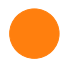

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F10:P:0_3</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAADu3ElEQVR4nOzdd3xb9fX/8dfV8LYznb2AEEYSQkjYe0PZtFBG6bfjB92UTjqhg0JLNy2jUEZpadkUKDOMDFYgECB77z0cb1uWdH9/HDseuteWZMl2nPfz8dAj8ZV09ZEt3Sudz/mc47iui4iIiIiIiIiIiIhIpgW6ewAiIiIiIiIiIiIi0jspAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkRaizO3AcZwzwFNAPeNF13S/7bXcc59fApY13vQ54HngcOBRYC5znum6532MNHDjQHTNmTGeHLCIiIiIiIiIiIiJpev/997e7rluazG07HYAGvgpMB64HtjqO80fXdZd4bQc%2BAn4NfBu4DIgCo4B9gOcat/3N74HGjBnDnDlzMjBkEREREREREREREUmH4zhrkr1tJkpwlAI7XNeNALuAgX7bXdf9D/AQ8BPgX4232em6rgtsbXHf3RzHucZxnDmO48zZtm1bBoYrIiIiIiIiIiIiIl0hEwHo7cAgx3FCQB9gi8/2isYSHJ8FvoQFobdjQWiw4PMW2nBd927Xdae6rju1tDSprG4RERERERERERER6QEyEYC%2BEzgeWIJlN3/TcZzJbbe7rjsPyMHKcPyw8fqXgTWO4ywHioBHMjAeEREREREREREREekBHKt%2BsWeYOnWqqxrQIiIiIiIiIiIiIt3HcZz3XdedmsxtM5EBLSIiIiIiIiIiIiKSQAFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCsUgBYRERERERERERGRrFAAWkRERERERERERESyQgFoEREREREREREREckKBaBFREREREREREREJCtC3T0AEeldysth3TrIzYV994VgsLtHJCIiIiIiIiIi3aXTGdCO44xxHGeu4zirHce5q73tjuNc6zjOcsdx1juOc0njtkrHcZY4jrPYcZyTOjseEeke77wD554LgwfDMcfA5Mn2/x//GHbt6u7RiYiIiIiIiIhId8hECY6vAtOBccBljuMc0M72ycAZwF%2BBTzmOMwIoAGqB1cAHGRiPiHQh14Wbb4ZTToHnnoP6eqishOpq2LEDfv97OPhg%2BOij7h6piIiIiIiIiIh0tUwEoEuBHa7rRoBdwEC/7a7rfh6IAl/AgtBbgSnAVCAfuKztzh3HucZxnDmO48zZtm1bBoYrIpniunDllfCrX0Ftrfdt6uth0ybLip4%2BvUuHJyIiIiIiIiIi3SwTAejtwCDHcUJAH2CL33bHcSYALwFfdV13FrAf8HUgBrhApO3OXde923Xdqa7rTi0tLc3AcEUkU266CZ5%2BGmpqOr5tTQ2cfz4sW5b9cYmIiIiIiIiISM%2BQiQD0ncDxwBLgIeCbjuNMbrvddd3lwIvAEOCvjuO8DazAMp9XAJXAYxkYj4h0gWefhVtuSS743KS62kp1VFdnb1wiIiIiIiIiItJzOK7rdvcYkjZ16lR3zpw53T0Mkb1edTWMHm01nlOVnw9f%2Bxr89reZH5eIiIiIiIiIiGSf4zjvu647NZnbZiIDWkT2Mj//eWqZzy3V1sLtt8Py5Zkdk4iIiIiIiIiI9DwKQItISpYvh7/%2B1b/pYDIiEbj66syNSUREREREREREeiYFoEUkJVdfbQHkzojF4N134X//y8yYRERERERERESkZ1IAWkSS9vbb8N57FkDurJoa%2BOY3YQ8qQy8iIiIiIiIiIilSAFpEktbZ0httbdkC77%2Bfuf2JiIiIiIiIiEjPogC0iCSlqgqeegri8czts67OGhKKiIiIiIiIiEjvpAC0iCTlsccgGMzsPmMxePTRzO5TRERERERERER6DgWgRSQpf/qTZUFnWkBHIRERERERERGRXkuhHxHp0OLFsGxZdvadjaC2iIiIiIiIiIj0DApAi0iH7r4botHuHoWIiIiIiIiIiOxpFIAWkXY1NMB999m/IiIiIiIiIiIiqVAAWkTa9eKL4LrdPQoREREREREREdkTKQAtIu169FGoqOjuUYiIiIiIiIiIyJ5IAWgR8eW68MIL3T0KERERERERERHZUykALSK%2Bli6F2truHoWIiIiIiIiIiOypFIAWySLXhXi8u0eRvpdfVv1nERERERERERFJnwLQIhm2aRPccAMceCCEQhAMQr9%2BcMUV8Prr3T261Dz%2BuDKgRUREREREREQkfQpAi2RINAq33gpjx8JvfgNLljRnP%2B/aBf/5D5x3HpxxBqxZ061DTUo0Cu%2B%2Bm9p9xo2Dv/4VFiyAt9%2BGa66B/PzsjE9ERERERERERHq%2BUHcPQKQ3qK2FCy6AN9%2BEmhr/21VXWxb0pEnwyiswdWrXjTFVH30E4TDU1SV3%2B09/Gu691%2B6Tk2PbJk6Eb30LTj0VNm7M3lhFRERERERERKRnUga0SCdVV8Mxx8CsWe0Hn5tEo1BeDiedBNOnZ3t06Zs5Exoakrvtj35kwefCwubgM9jP%2B%2B0HH39sJUlERERERERERGTvogC0SCe4Llx1FSxenHymcJPqasuaXrs2O2PrrOefT%2B45TZ0KP/6xBZu9hMNWA/uxxyCgI46IiIiIiIiIyF5F4SCRTrjtNnj55dSDz02qq%2BGss9K/f7a4LrzzTse3CwbhX/%2BCvLz2bxcIwJgx8OUvZ2R4IiIiIiIiIiKyh1AAWiRNb70FP/yhBZHTFYvB6tXwpS9lbFgZsWSJBaE78s1vwvDhyWU2FxVZc8bBgzs/PhERERERERER2TMoAC2ShoYG%2BNSnrPlgZ9XWwhNPwLRpnd9Xpnz4YcdB5WHD4Be/sMByssJhuOuuTg1NRERERERERET2IApAi6ThwQehsjJz%2B6uuhu98J3P766yPPoKqqvZvc%2B21EAqltt/cXDjzTBg1Kv2xiYiIiIiIiIjInkMBaJEURSJWeqOjAG2qVq7M7P46Y/bs9ktwBINw9dUWUE6V49h9JQPcOGydCQt

<h3>Cluster 3 (11 motifs)</h3>

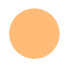

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F3:P:0_2</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAD0eklEQVR4nOzdd3wb9f3H8ddp2PKKnb03JCEBQiBsCpSW3dIyyygt9Eehm5a20FJaCoUWSvei0JZS9h5ljwJhQwIBEsjezvCMp2xZ435/fO3Ykk6yZJ1sJ7yfj4cfiU%2Bnu7Mtne4%2B38/387Fs20ZERERERERERERExG2egT4AEREREREREREREdk1KQAtIiIiIiIiIiIiInmhALSIiIiIiIiIiIiI5IUC0CIiIiIiIiIiIiKSFwpAi4iIiIiIiIiIiEheKAAtIiIiIiIiIiIiInmhALSIiIiIiIiIiIiI5IUC0CIiIiIiIiIiIiKSFwpAi4iIiIiIiIiIiEheKAAtIiIiIiIiIiIiInnhG%2BgDSGfEiBH2lClTBvowRERERERERERERKTTO%2B%2B8U2vb9shM1h3UAegpU6awaNGigT4MEREREREREREREelkWdaGTNdVCQ4RERERERERERERyQsFoEVEREREREREREQkLxSAFhEREREREREREZG8UABaRERERERERERERPJCAWgRERERERERERERyQsFoEVEREREREREREQkLxSAFhEREREREREREZG8UABaRERERERERERERPJCAWgRERERERERERERyQsFoEVEREREREREREQkLxSAFhEREREREREREZG8UABaRERERERERERERPIiqwC0ZVlTLMtabFnWesuy/p5uuWVZ37Esa7VlWZWWZZ1uWZbPsqxHOtd52bKscrd/GBEREREREREREREZPLLNgP4G8BIwAzjTsqyZaZbPA44B/gKc1vn/ScBUoAU4M8djFxEREREREREREZFBLNsA9EigzrbtDqABGJFquW3b5wMR4CuYIPRIoN62bRuo7vHcOJZlXWhZ1iLLshbV1NRkeXgiIiIiIiIiIiIiMlhkG4CuBUZZluUDyoGqVMsty9oTeAb4hm3br3SuM7Jz/RE9nhvHtu2bbdueb9v2/JEjRzqtIiIiIiIiIiIiIiI7gWwD0DcCnwBWAHcCF1uWNS9xuW3bq4GngTHAXyzLegN4FthgWdZqoBS4150fQUREREREREREREQGI182K9u2vRZT29nJvIR1Jzisc1I2%2BxMRERERERERERGRnVe2GdAiIiIiIiIiIiIiIhlRAFpERERERERERERE8kIBaBERERERERERERHJCwWgRURERERERERERCQvFIAWERERERERERERkbxQAFpERERERERERERE8kIBaBERERERERERERHJCwWgRURERERERERERCQvFIAWERERERERERERkbxQAFpERERERERERERE8kIBaBERERERERERERHJCwWgRURERERERERERCQvFIAWERERERERERERkbzwDfQBiIiIiIi4xrah%2BmWofR28AZh4KpRMGuijEhERERH52FIAWkRERORjJBqL0hxqpqKoYqAPxX1Nq%2BDV06F5NcTawfLB%2B5fD5LNg/7%2BDt2Cgj1BERERE5GNHJThEREREPkYeWf4II24YMdCH4b7G5fDsgdDwAURbwY5CLATRdthwD7x0AkRDA32UIiIiIiIfOwpAi4iIiHyMbG/bTsyOYdv2QB%2BKe0J18Nxh0NEAOPxc0TZTkuO1s/v7yEREREREPvYUgBYREfk4sWMDfQQywOrb67GxaQ23DvShuOetCyDSjGPwuUu0DbY%2BDZse7rfDEhERERERBaBFRER2fdEQrLoJHp4Ad3vh3hJYdDG0bR3oI5MBsL1tOwC1wdoBPhKXVP4Xtj4LsY7e140G4c3zIVSf/%2BMSERERERFAAWgREZFdW7jZlCZ49xJo22yWRYOw%2BiZ4fA/Y/t6AHp70v67Ac01rzQAfiQtsG9652LymMxULwfLf5%2B%2BYREREREQkjgLQIiIiu6pIKzx7MDQsSQ7QxUIQboTnDof6xQNzfDIgqlqqgF0kA3rLkxDK8ueItsOKP5j3h4iIiIiI5J0C0CIiIruqRd%2BGljUm2JxKpBkWfBYiWWSQyk6tJmgyn3eJAPT7P4FIS/bPs2Ow6mb3j0dERERERJIoAC0iIrIr2vI0bLjXZHv2pqMeFn0n/8ckg0JdWx3QHYjeaVW/Cs2r%2B/bcaBA%2BvBaiGdSNFhERERGRnCgALSIisquJRUyjtUzr4kbbYMNdsP2D/B6XDAqN7Y1AdymOndaSn2VX%2BzlRLAQb7nbveERERERExJEC0CIiIruaDfdmX5YgFoIPfpKf45FBpaXDvDYqmyoH%2BEhyEKqHmtcAu%2B/biLTAqr%2B7dkgiIiIiIuJMAWgREZFdiR2D93%2BcfQDajsG256FpRX6OSwaFaCxKsLPe99aWrQN8NDnY8hR4CnLfzvZ3c9%2BGiIiIiIikpQC0iIjIrmTTQ9CxvW/PjYXhg5%2B5ezwyqGxv735t1LTuxDWgN9zVt%2BaDiTyFuW9DRERERETSUgBaRERkV2Hb8N6P%2Bh6Ys6Ow%2Bb/Qstbd45JBozZYu%2BP/9W31A3gkOYh2QNUL7mwr0uzOdkREREREJCUFoEVERHYV29%2BF9m25bSMWhTW3unI4MvjUBmvxWT4AGkONA3w0fVS9ACwXym%2BIiIiIiEi/UABaRERkV7HxfpMdmgs7DOvvdOd4ZNCpaa3BsiwsLILhINFYdKAPKXsb73en/IaIiIiIiPQLBaBFRER2FevvMgHkXLXvxM3pJK2eJTgKfYU7XxkO2zZ1zokN9JGIiIiIiEiGFIAWERHZFTSthFBt7%2BtlxHZpOzLYVLdWE46ZQQq/x09NcCdrRNjwAcTaB/ooREREREQkCwpAi4iI7Ao2PWiyQ90QVYBvV7W1pTu73WN54jKidwqbHoaYC1n%2BIiIiIiLSbxSAFhER2RWsu0OZodKryqbKHf%2B3salp3ckyoDc9BLEc65yLiIiIiEi/8g30AYiIiHxcLV0K99wDr78OPh8ceyycfjpMmpTlhoJboGVNXo5Rdi1VrVU7/h%2BOhneuDOhYGJpXDPRRiIiIiIhIlhSAFhER6Wfbt8OFF8KTT0IkAh2dCZ2vvgo//Sl8%2B9vwi19AQUGGG9z8KFg%2BIJSvQ5ZdRM%2BAcyga2rkC0A0fgKdQGdAiIiIiIjsZleAQERHpR%2BvWwaxZ8NhjEAx2B58B2trM11/%2BAvvvD01NGW507X8g2pqX45Vdy/a27Tv%2BH7NjcSU5Br3at8CODPRRiIiIiIhIlhSAFhER6ScbN8JBB0FtLYTSJCsHg7BiBRxxBLS09LLRaAdsX%2Bzqccquq7mjOe77LS1bBuhI%2BmDb/yDaNtBHISIiIiIiWVIAWkREpB9EInDiiVBXB7FY7%2BuHQrB8OVx0US8rbl8MnoArxyi7trZwG9FYNG5ZVUtVirUHodo3BvoIRERERESkD1QDWkREpKdQvQl0NS41Tc%2BKJ8KIQ2DI7jlt9pprYO1aiEZ7X7dLezs88gj8979w0kkpVqp9A2Kq/Sy9qw3WUugrJBgOxi

<h3>Cluster 4 (2 motifs)</h3>

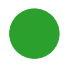

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>STFT:T2:P:0_4</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAD5BUlEQVR4nOzddXxcZdbA8d8dy8SaurtToRRKgQqluOvivsgCiy3u/rK7wO4ii/sCRUpxKfUWqrTU3Zt60yZpfOy%2Bf5xMY3Mnk2RmMknPl898SGcmMzcj9z73POc5xzBNE6WUUkoppZRSSimllFIq2mz1vQFKKaWUUkoppZRSSimlGicNQCullFJKKaWUUkoppZSKCQ1AK6WUUkoppZRSSimllIoJDUArpZRSSimllFJKKaWUigkNQCullFJKKaWUUkoppZSKCQ1AK6WUUkoppZRSSimllIoJDUArpZRSSimllFJKKaWUigkNQCullFJKKaWUUkoppZSKCQ1AK6WUUkoppZRSSimllIoJDUArpZRSSimllFJKKaWUiglHfW9ATbRs2dLs2rVrfW%2BGUkoppZRSSimllFJKHbQWLFiQZZpmq0ju26AC0F27dmX%2B/Pn1vRlKKaWUUkoppZRSSil10DIMY3Ok99USHEoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWJCA9BKKaWUUkoppZRSSimlYkID0EoppZRSSimllFJKKaViQgPQSimllFJKKaWUUkoppWLCUd8boJRSSimllFJKxZvHA1OmwMSJsHcvZGTAscfCqadCamp9b51SSinVeGgAWimllFJKKaXUQaOwEB58EN55BxwOyMsD05Tb3n9fAtPnnw%2BvvAItWtTvtiqllFKNgZbgUEoppZRSSil1UJgxA3r2hLfflkD0/v1lwWeQYHRJCYwbBz16wFdf1d%2B2KqWUUo2FBqCVUkoppZRSSjV6X34Jp50GO3ZAUVH4%2B3o8kJsLV14Jzz8fn%2B1TSimlGisNQCullFJKKaWUatTGjoWrrpKs55ooLIQnntAgtFJKKVUXGoBWSimllFJKKdVoTZ8O11xTfdazlWAQ%2BsMPo7lVSiml1MFDA9BKKaWUUkoppRqlrCxpKFjTzOfKCgvhlltg9erobJdSSil1MNEAtFJKKaWUUkqpRsc04cILIT8/Oo9XVARnngnFxdF5PKWUUupgoQFopZRSSimllFKNzptvwu%2B/S0PBaDBN2LYNHnooOo%2BnlFJKHSw0AK2UUkoppZRSqlHJzYX774eCgug%2BblERvP46rF8f3cdVSimlGrM6B6ANw%2BhqGMZCwzA2GYbxRrjrDcM4yTCMMYZhfFnufnmGYaw2DGOVYRjH1XV7lFJKKaWUUkod3B55JHqZz5V5vVIPWimllFKRiUYG9C3ANKA3cIlhGH3CXJ8OZAJNAQzD6AikAEXAJuCPKGyPUkoppZRSSqmD1Nq18O67savV7PfDb7/B1KmxeXyllFKqsYlGALoVsNc0TQ%2BQA7S0ut40za%2BAleV%2BdzdwBDAESAYuqfzghmHcaBjGfMMw5u/ZsycKm6uUUkoppZRSqrGKZfZzUGEh3H13bJ9DKaWUaiyiEYDOAlobhuEAMoBd1VxfXg/gVsAPmECVYYJpmm%2BZpjnENM0hrVq1isLmKqWUUkoppZRqjHbuhO%2B%2BkyzlWFu9OvbPoZRSSjUG0QhAvw6MBFYDnwB3GIYxuPL1pmmuC/G765HM5/VAHjA2CtujlFJKKaWUUuog9NJLYJrxea5YlfhQSimlGhvDjNfROQqGDBlizp8/v743QymllFJKKaVUgikqgjZtIC8vfs/ZgE6nlVJKqagyDGOBaZpDIrlvNDKglVJKKaWUUkqpevXxxxAI1PdWKKWUUqoyDUArpZRSSimllGrQTBP%2B7/%2BgoKC%2Bt0QppZRSlWkAWimllFJKKaVUgzZ5MuzdW99boZRSSqlQNACtlFJKKaWUUqpBe/ttyM%2Bv761QSimlVCgagFZKKaWUUkop1WB5vfDDD/W9FUoppZSyogFopZRSSimllFIN1tSpYLfX91YopZRSyooGoJVSSimllFJKNVgff6zlN5RSSqlEpgFopZRSSimllFINkt8P33wDplnfW6KUUkopK4763gCllFJKKaWUUqo2Zs2q/e8aBgwfDhdeCF26wK5d8PXXMHmy1JVWSimlVHRoAFoppZRSSimlVIP03XdQVFTz3xswAD7/HDp1guRkcDggEICLL5ZyHpddBjNmRH97lVJKqYORluBQSimllFJKKdUgffUV%2BHw1%2B51zz4W5c6FvX0hPl%2BAzgM0GGRnQoQP89BPccUfUN1cppZQ6KGkGtFJKKaWUUkqpBmfHDti2rWa/c/bZ8MknkJIS/n6pqfB//ye1pV9%2BufbbqJRSSinNgFZKKaWUUkop1QCNHw9OZ%2BT379YtsuBzUGoq/P3vcMwxtds%2BpZRSSgkNQCullFJKKaWUanDGjpV6zZGw26XBoNtds%2BdISZEyH%2BnpNd8%2BpZRSSgkNQCullFJKKaWUalBME2bNivz%2Bjz4KPXqU1XuuiYwMePPNmv%2BeUkoppYQGoJVSSimllFJKNSjbt0NJSWT37dgR7rsP0tJq91zJyVI7%2Buija/f7Siml1MFOA9BKKaWUUkoppRqU%2BfPB5YrsvvfdB7Y6nvkmJ8MTT9TtMZRSSqmDlQaglVJKKaWUUko1KHPmRFb/OSMDrrsOkpLq9nw2G4wcCb161e1xlFJKqYORBqCVUkoppZRSSjUo06dDIFD9/W65RepFR4PTCQ8/HJ3HUkoppQ4mGoBWSimllFJKKdVgmCYsXVr9/VwuuPdeSE2NzvM6nXDRRdC6dXQeTymllDpYaABaKaWUUkoppVSDsWUL%2BP3V3%2B/yy8HhiP7z/%2B1v0X9MpZRSqjHTALRSSimllFJKqQZj/vzIAssPPADp6dF97uRkKetht0f3cZVSSqnGTAPQSimllFJKKaUajNmzoaAg/H26dYOOHWPz/KYJxx4bm8dWSimlGiMNQCullFJKKaWUajAiaUD4pz%2BBYcTm%2BdPS4IorYvPYSimlVGOkAWillFJ

<h3>Cluster 5 (3 motifs)</h3>

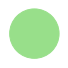

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F4:P:0_8</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAACsN0lEQVR4nOzdd3xb1f3/8dfVsLzt2HGcvTczEPbeq0ChpQU6KC0FCt2lk5aOb/ujLXSzOqAtqxQKpey9NwmQhOw9nDhx4ngPrfv74yPFQ7It2bITx%2B/n4yEcrqSrK1m%2B95zP%2BZzPcVzXRUREREREREREREQk0zy7%2BwBEREREREREREREZO%2BkALSIiIiIiIiIiIiI9AsFoEVERERERERERESkXygALSIiIiIiIiIiIiL9QgFoEREREREREREREekXCkCLiIiIiIiIiIiISL9QAFpERERERERERERE%2BoUC0CIiIiIiIiIiIiLSLxSAFhEREREREREREZF%2BoQC0iIiIiIiIiIiIiPQL3%2B4%2BgLjhw4e7EydO3N2HISIiIiIiIiIiIiLdmD9//nbXdctSeeweE4CeOHEi8%2BbN292HISIiIiIiIiIiIiLdcBxnfaqPVQkOEREREREREREREekXaQWgHceZ6DjO%2B47jrHMc57butjuOc5PjOJWO4yxzHOcPmT5wEREREREREREREdmzpZsBfRXwEjAduNBxnBndbJ8J1AIu8GgmDlZEREREREREREREBo90A9BlwA7XdYNADTC8m%2B1XAUcCNwI/S7Yzx3EudxxnnuM486qqqtI/ehERERERERERERHZY6UbgN4OjHAcxwcUAVu72f41YAIQAYLJdua67l9c153ruu7csrKUFk0UERERERERERERkUHCl%2BbjbwUeBJYD9wBfcxznjs7bXddd5TjOG8ADQBPwpcwdsoiIiIiIiIiIiIgMBmkFoF3XXQPM6eLuOZ0eew8WpBYRERERERERERGRISjdEhwiIiIiIiIiIiIiIilRAFpERERERERERERE%2BoUC0CIiIiIiIiIiIiLSLxSAFhEREREREREREZF%2BoQC0iIiIiIiIiIiIiPQLBaBFREREREREREREpF8oAC0iIiIiIiIiIiIi/UIBaBERERERERERERHpFwpAi4iIiIiIiIiIiEi/UABaRERERERERERERPqFAtAiIiIiIiIiIiIi0i8UgBYRERERERERERGRfqEAtIiIiIiIiIiIiIj0CwWgRURERERERERERKRfKAAtIiIiIiIiIiIiIv1CAWgRERERERERERER6RcKQIuIiIiIiIiIiIhIv1AAWkRERERERERERET6hQLQIiIiIiIiIiIiItIvFIAWERERERERERERkX6hALSIiIiIiIiIiIiI9AsFoEVERERERERERESkXygALSIiIiIiIiIiIiL9QgFoEREREREREREREekXCkCLiIiIiIiIiIiISL9QALo3QnXQtAkiwd19JCIiIiIiIiIiIiJ7LN/uPoBBpfo9%2BOAHsO1FcHzgeGDa1bDP9yCreHcfnYiIiIiIiIiIiMgeRRnQqVr/ADx7DFQ%2BA9EgRJog3ADLfw9PHghNFbv7CEVERERERERERET2KApAp2L9/fDWJRZ0xu14X7TVgs9PHQQt23bL4YmIiIiIiIiIiIjsiRSA7knDWnj78xBp7voxbhhad8JrnwDX7fpxIiIiIiIiIiIiIkOIAtDdiUbglfMg0tLzY90Q7JgHK/7U/8clIiIiIiIiIiIiMggoAN2dDfdDwypwI6k9PtIIC66FUF3/HpeIiIiIiIiIiIjIIKAAdFeiEfjgOxBuTO95bgSW/a5/jklERERERERERERkEFEAuisb7odgTfrPizTD0huVBS0iIiIiIiIiIiJDngLQyezKfm7o3fOVBS0iIiIiIiIiIiKSXgDacZyJjuO87zjOOsdxbkth%2ByzHcZocx/l0Jg%2B63216qHfZz3HxLOhwU8YOSURERERERERERGSwSTcD%2BirgJWA6cKHjODO62u44ThZwO7AtM4c6gFb%2BpffZz7t4YMvTGTkcERERERERERERkcEo3QB0GbDDdd0gUAMM72b7L4G7gHVd7cxxnMsdx5nnOM68qqqqNA%2Bln4QaoOrVvu8nXAdr7%2Bz7fkREREREREREREQGKV%2Baj98OjHAcxwcUAVu72B4GPg1UA%2BOxzOi7O%2B/Mdd2/AH8BmDt3rtubN5BxW54ETxZEWzOwL2VAi4iIiIiIiIiIyNCVbgb0rcAxwHLgHuBrjuPM6bzddd23Xdcd4bruTOAd4DsZPOb%2BteafEK7PzL4cf2b2IyIiIiIiIiIiIjIIpZUB7bruGmBOF3cn3e667vFpHtPuE26GyuczuL8MBbJFREREREREREREBqF0M6D3bpXPgCeTWct7RlURERERERERERERkd1BAej21t6lrGURERERERERERGRDFEAOi4ShM1P7u6jEBEREREREREREdlrKAAdV/UqeNIqiS0iIiIiIiIiIiIi3VAAOm7rSxBu2t1HISIiIiIiIiIiIrLXUAA6bstT4IZ391GIiIiIiIiIiIiI7DUUgAaIhqFm0e4%2BChEREREREREREZG9igLQADULwZO1u49CREREREREREREZK%2BiADRA1esqvyEiIiIiIiIiIiKSYQpAA1Q%2BD5Hm1B47/Wo4bzNcGIRTXoPSQ/v32EREREREREREREQGKQWgAarnpfa4Q/8KB/4SckaBxw9lR8FJL0D5if17fCIiIiIiIiIiIiKDkALQoTpo2dbz4w76HUy8EHz5Hbf78uC4R5QJLSIiIiIiIiIiItKJAtDV74Mvp/vHFEyHqVckBp/jfHlw6F8yf2wiIiIiIiIiIiIig5gC0NXzINLS/WPm3GAlN7qTPwVGn5m54xIREREREREREREZ5BSA3vYyRINd3198AIw8GTy%2B7vfjz4eD/wA4GT08ERERERERERERkcFKAeiaD7u//%2BDfgSeQ2r6yy2H8BX0/JhEREREREREREZG9wNAOQLsuNG/u%2Bv7csTD8cPB4U9ufvwBmXZOZYxMREREREREREREZ5IZ2ALqlkm5LZow7H9xoevss3h8Cw/t0WCIiIiIiIiIiIiJ7g6EdgK5fCd5uymtMvhR8eentMxqCsef27bhERERERERERERE9gIKQEfDye/LLofCmenv058Pkz7Xp8MSERERERERERER2RsM7QB07VKINCa/b%2BxHuw5O96R0LviLen1YIiIiIiIiIiIiInuDoR2A3rmg6/smX2rZzL0RDcKYs3v3XBEREREREREREZG9xNAOQNevTL7dmwMlc3q/X38hjP9E758vIiIiIiIiIiIishcYugFoNwotm5PfV3oIhJv7tv%2ByI/v2fBEREREREREREZFBbugGoJs3g%2BNLfl/Z0ZYF3RfeXMgd27d9iIiIiIiIiIiIiAxiQzcAXb8SPFnJ7xt1Bni7uC9VbgjKjurbPkREREREREREREQGsaEdgI6Gkt9XcmDf9%2B/Lh7Jj%2Br4fERERERERERERkUFq6Aaga5dCpClxe94EwOn7/h2PAtAiIiIiIiIiIiIypA3dAHT9yuTbS%2BZCNJyZ1yickZn9iIiIiIiIiIiI

<h3>Cluster 6 (2 motifs)</h3>

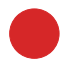

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F9:P:0_2</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAADlpElEQVR4nOzddZwc9f3H8desnN/l4m5EcQLB3V2KFWiBGm4tLaXU6K8CpS2lBVq0SKFIkeJO0CAhxJUIcbnLJTmXlfn98d3Lyc7srczeXS7vJ499cJmdnfnu3u3uzGc%2B38/Hsm0bERERERERERERERGv%2Bbp6ACIiIiIiIiIiIiLSMykALSIiIiIiIiIiIiJZoQC0iIiIiIiIiIiIiGSFAtAiIiIiIiIiIiIikhUKQIuIiIiIiIiIiIhIVigALSIiIiIiIiIiIiJZoQC0iIiIiIiIiIiIiGSFAtAiIiIiIiIiIiIikhUKQIuIiIiIiIiIiIhIVigALSIiIiIiIiIiIiJZoQC0iIiIiIiIiIiIiGRFINMNWJY1Cvgf0Bt4w7bty92WW5b1R%2BDc2EN/aNv2S5ZlVQPrABu43Lbt99321a9fP3vUqFGZDllERERERERERERE0vTll19usm27fzLrZhyABq4E3gduBMosy7rDtu3FTsuB2cAfgeuB8yzLmgEUAPXABmBGoh2NGjWK6dOnezBkEREREREREREREUmHZVkrk13XixIc/YEK27abgK1AP7fltm0/CfwH%2BCXwOFAG7ANMBvKB89pv3LKsSy3Lmm5Z1vTy8nIPhisiIiIiIiIiIiIincGLAPQmYIBlWQGgF7DRZXlVrATHRcBlmCD0GOBqIIIpwdHUfuO2bd9v2/Zk27Yn9%2B%2BfVFa3iIiIiIiIiIiIiHQDXgSg7wEOBRZjspuvsyxrUvvltm3PBXIwZThuit2/DJP5vAyoBp7xYDwiIiIiIiIiIiIi0g1Ytm139RiSNnnyZFs1oEVERERERERERES6jmVZX9q2PTmZdb3IgBYRERERERERERERiaMAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFYoAC0iIiIiIiIiIiIiWaEAtIiIiIiIiIiIiIhkhQLQIiIiIiIiIiIiIpIVCkCLiIiIiIiIiIiISFZkHIC2LGuUZVkzLctaYVnWvYmWW5b1R8uylsdup1mWFbAs64XYOh9altUr0/GIiIiIiIiIiIiISPfgRQb0lcD7wHjgPMuyJiRYPhvYG3gcOA84DhgBjAZqYstEREREREREREREpAfwIgDdH6iwbbsJ2Ar0c1tu2/aTwH%2BAX2KC0P2BzbZt20BZq8duY1nWpZZlTbcsa3p5ebkHwxURERERERERERGRzuBFAHoTMMCyrADQC9josrzKsqw/AhcBl2GC0JswQWgwweeNtGPb9v22bU%2B2bXty//79298tIiIiIiIiIiIiIt1UwINt3AM8ByzGZDdfZ1nWQ%2B2X27Y917KsHEwZjibgZuAt4DLLspYCa4CnPRhP92FHYeMU2DoXrCAMPhZKJnT8OBEREREREREREZEewDLVL7YPkydPtqdPn97Vw0jOymdg%2BtUQqYNoE1g%2BwIJeu8JBT0DJuK4eoYiIiIiIiIiIiEjKLMv60rbtycms60UJDmnNjsKX18Nn34HGMgjXmAB0pAEi9bB5BryxN6x9ratHKiIiIiIiIiIiIpJVCkB7beaNsPQ%2Bk/nsKGqC0h%2BfDWUfd%2BrQRERERERERERERDqTAtBe%2BvoJWPLPBMHnViL18MEpULMi68MSERERERERERER6QoKQHulbh1MuyS54HOzcA1MPRe2ozrcIiIiIiIiIiIiIslSANorX14H0VBqj7EjULkA1vwvO2MSERERERERERER6UIKQHth02ew7lWwUwxAA4RrYdoVpkmhiIiIiIiIiIiISA%2BiAHSm7Ch89n1T0zld4RpY8CfvxiQiIiIiIiIiIiLSDSgAnanVz0Pdqsy2EamDBbdB01ZPhiQiIiIiIiIiIiLSHSgAnalFfzMZzJmyLFj5VObbEREREREREREREekmFIDORN1a2Dzdm22Fa2HxXd5sS0RERERERERERKQbUAA6E1//22Que6X2a%2B%2B2JSIiIiIiIiIiItLFFIBOl23DV/%2BASIN324yGvduWiIiIiIiIiIiISBdTADpdFZ9DaKu327RD3m5PREREREREREREpAsFunoA260l90KkvqtHISIiIiKSlA0b4IEHYPZsKC2Fb30LjjjC24pyIiIiIiLtKQCdjnA9rHoG7GhXj0REREREJKFoFG64Af75T/PvhlgFuaefhiFD4LXXYMyYrhufiIiIiPRsCkCnY91rYPm7ehTdQ6QBNn8JoWrI7Qe9J4FPr42IiIhId1BfD9/4Bnz0UUvguVlNDSxdCnvvDa%2B/Dgcd1DVjFBEREZGeTQHodKx5AcLVXT2KrlW5CGZcDxungD8XsExGuB2B4WfBpNsgf3BXj1JERERkh2XbcPHF8MEH8cHnZtEoVFXBCSeY0hyjR3fuGEVERESk51MTwlTZNqx/s6tH0XXsKMz8GbyxN2x4E6KNEKqCUKUJykfqYOVT8NJYWPpgV49WREREZId1333w6qvuwefW6urgxBOTW1dEREREJBUKQKeqZhmEa7p6FF0j0gAfnA5f3WUaMLrVwLZDJhD95XUw48cmaC8iIiIinWbVKrj%2BehNYTkYkYh7z619nd1wiIiIisuNRADpVG94Gum%2Br8MpK%2BPxz%2BOQTWLvWww3bNnzyLdj4rgkuJyNSB0vuhXm/83AgIiIiItKRG26AUCi1x9TXw913w/r12RmTiIiIiOyYFIBO1eoXkw/AAvSZDDvfAOOuzFpN5GgUnnoKJk6EAQPguOPgpJNg7FgYOBB%2B8xvTZCYjC/4I6940mc%2BpiNSZx655OcMBiIiIiEgy5s6Fl1%2BGcDj1x0YicNNN3o9JRERERHZclr0dlUeYPHmyPX369K4bgG3Ds6Wm5nFHAkVw2AvQd3/w5YAdBsuCub%2BDBbe6P%2B6C1H4fH3wAP/iByVSprXVep6AAgkH4wx/gyivNMFKy7g346MzUg8%2BtBQrh%2BGnQa5f0tyEiIiIiHTrqKHOMGHWpltaR/HyYNQvGj/d0WCIiIiLSg1iW9aVt25OTWVcZ0KmoWQbRJFJJ8gbBCV9Cv4MgWAT%2BHAgUgD8fdv057P8QXpTxeOkl0yxm6VL34DOY2n%2BVlXDjjXDddSmWZA7XwdQLMgs%2Bb9vOeZltQ0REREQS%2BugjU44t3eAzQFMT/PCHng1JRERERHZwGQegLcsa

<h3>Cluster 7 (3 motifs)</h3>

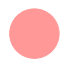

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F5:P:0_4</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAACXP0lEQVR4nOzdd5wkVbn/8U9V58mzEzfnACwsS84oIkEFFfEa8YqKIj8UM95rAkVU1KvXDAoXAyZUJIvknHdhYXfZyOadnGOHqt8fp3t6QvXEnrT7fb9e/ZqZ6p7q07HOeeo5z7Fc10VEREREREREREREJNvsyW6AiIiIiIiIiIiIiByYFIAWERERERERERERkXGhALSIiIiIiIiIiIiIjAsFoEVERERERERERERkXCgALSIiIiIiIiIiIiLjQgFoERERERERERERERkXCkCLiIiIiIiIiIiIyLhQAFpERERERERERERExoUC0CIiIiIiIiIiIiIyLhSAFhEREREREREREZFx4Z/sBqSUlpa6CxYsmOxmiIiIiIiIiIiIiMggXnzxxTrXdcuGc9spE4BesGABL7zwwmQ3Q0REREREREREREQGYVnWzuHeViU4RERERERERERERGRcKAAtIiIiIiIiIiIiIuNCAWgRERERERERERERGRcKQIuIiIiIiIiIiIjIuFAAWkRERERERERERETGhQLQIiIiIiIiIiIiIjIuFIAWERERERERERERkXGhALSIiIiIiIiIiIiIjAsFoEVERERERERERERkXCgALSIiIiIiIiIiIiLjQgFoERERERERERERERkXCkCLiIiIiIiIiIiIyLhQAFpERERERERERERExoUC0CIiIiIiIiIiIiIyLhSAFhEREREREREREZFxoQC0iIiIiIiIiIiIiIwLBaBFREREREREREREZFwoAC0iIiIiIiIiIiIi40IBaBEREREREREREREZFwpAi4iIiIiIiIiIiMi4UABaRERERERERERERMaFAtAiIiIiIiIiIiIiMi4UgBYRERERERERERGRcTGiALRlWQssy1prWdYOy7J%2BNYzth1iW1WFZ1gez2WgRERERERERERERmfpGmgF9GfAIsAx4r2VZyzNttywrCNwI1GSnqSIiIiIiIiIiIiIynYw0AF0G1LuuGwWagNJBtn8X%2BD2wI9POLMv6uGVZL1iW9UJtbe0ImyIiIiIiIiIiIiIiU5l/hLevA8oty/IDhUB1hu1x4INAAzAPkxn9h/47c133BuAGgGOOOcYdzQMQERERERERERERkalppBnQvwROBTYBtwBXWJa1uv9213WfdV233HXdFcBzwJey2GYRERERERERERERmQZGlAHtuu52YHWGqz23u677hhG2SUREREREREREREQOACPNgBYRERERERERERERGRYFoEVERERERERERERkXCgALSIiIiIiIiIiIiLjYkQ1oMVDVw3s%2BBPUPAq4UHoSLPgA5Mya7JaJiIiIiIiIiIiITCoFoEcrEYW1X4CtN4BlQ6LTbN9/H6z7mglCH/Mz8Ecmt50iIiIiIiIiIiIik0QlOEajswruPRK23QhOdzr4DOZ3pxt2/gnuPgzad05aM0VEREREREREREQmkwLQIxVrgQdOg9YtkOjIfLtEJ3TsgvtPha66iWufiIiIiIiIiIiIyBShAPRIOAl46Gxo3wVufOjbuwnorIYHzzAlO0REREREREREREQOIgpAj8Tmn0DTOlNiY7jcKLRtg/XXjl%2B7RERERERERERERKYgBaCHq303vPzVwctuZJLogI3XQcvm7LdLREREREREREREZIpSAHo4XBee%2BTA4Yyij4XTDUx80%2BxIRERERERERERE5CCgAPRx7boO6Z4dX9zkT14HmDbD9puy1S0RERERERERERGQKUwB6KK4La6%2BERPvY95Voh5e/Nvb9iIiIiIiIiIiIiEwDCkAPpf5Z6Nyfvf3FW7O3LxEREREREREREZEpTAHooWz8ISQ6s7e/eFv29iUiIiIiIiIiIiIyhSkAPZjueth7F%2BBMdktEREREREREREREph0FoAez7Saw9BSJiIiIiIiIiIiIjIaiq5m4Drz2I0h0THZLRERERERERERERKYlBaAzqXpQCwaKiIiIiIiIiIiIjIEC0Jm89j9aMFBERERERERERERkDBSA9pLohupHJrsVIiIiIiIiIiIiItOaAtBeah4DOzjZrRARERERERERERGZ1hSA9rLnNpXfEBERERERERERERkjBaC97L4NcCa7FSIiIiIiIiIiIiLTmn%2ByGzDltG6DWPPI/qfkWJh5NmBD1QNQ99S4NE1ERERERERERERkOlEAur/qhwBreLcNFsNpt0Hx0eALm/875AvQ8ho8%2BjboqhnPloqIiIiIiIiIiIhMaSrB0d/eOyDRMfTt8pfBW9dDyfEQyAPbD7YPAvlQtMpcV3TE%2BLdXREREREREREREZIpSALo314Wax4a%2BneWH0%2B%2BAUEUy87kfXxBCpXD6Xd7Xi4iIiIiIiIiIiBwEFIDurWUjuImhb3fYf0NkNthDPH2hElh1bXbaJiIiIiIiIiIiIjLNKADdW82j4DqD36bwMDj0SlN2Yyj%2BHFjyCbNIoYiIiIiIiIiIiMhBRgHo3mqfgkTn4Lc56RawQ8Pfpy8MJ/1pbO0SERERERERERERmYYUgO6t/vnBry85FvIWm8UGh8uyIVwOFWeMrW0iIiIiIiIiIiIi04wC0ClOAtpfH/w2Kz43ukUF/blwyBdG1y4RERERERERERGRaUoB6JS2rWAHM18fLIY5bwfbP/J9WzZUvAEiM0fdPBEREREREREREZHpRgHolKZ1DPp0LPrw0AsUDsYFllw6%2Bv8XERERERERERERmWYUgE5pWAPxtszXr/i8KaUxWv4ILLscrBHUjxYRERERERERERGZxhSATql9CsiQ4Vx8JAQKx34ftg/KTh77fkRERERERERERESmAQWgU5pfzXzd7PPADoz9Pny5MPsdY9%2BPiIiIiIiIiIiIyDSgADRAtBHirZmvn/ce8IXGfj%2B2H%2Ba9a%2Bz7EREREREREREREZkGFIAGaFwHvhzv64IzIH9J9u4rVJa9fYmIiIiIiIiIiIhMYSMKQFuWtcCyrLWWZe2wLOtXg223LOu7lmVtT17Oz3bDs6rpZUh0e19XfjokurJ3X248e/uaDG3bYduN8NqPYccfoat2slskIiIiIiIiIiIiU5R/hLe/DHgEuBKosSzrR67rbvLaDrwMfBf4HPBe4I4stTn7ml4BJ0OQeeY54M/P3n0FsriviVT1EDz3CejcC9jgxsAOgROFkmPhuF9D4YrJbqWIiIiIiIiIiIhMISMtwVEG1LuuGwWagNJM213X/RNwC/BV4A9eO7Ms6%2BOWZb1gWdYLtbWTmEnbujXzdbPOAfsgrlSSiMKT74dHz4O2rZDohES7CTzHW8Hphtqn4F9HwfrvgOtOdotFRERERERERERkihhpZLUOKLcsyw8UAtUZtrdYlvVd4EPAJzBB6AFc173Bdd1jXNc9pqxsEmsjd%2Bz23u7Pg0jlxLZlKol3wMNnwZ5/QqJjkBs6JjD96jWw5nMKQouIiIiIiIiIiAgw8gD0L4FTgU2Y7OYrLMta3X%2B767qv

<h3>Cluster 8 (5 motifs)</h3>

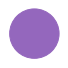

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>STFT:T2:C:0_4</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAADJ/ElEQVR4nOzdd3xddf3H8de5Izvp3rullBYoq%2BwlICBbBBEQ/IGoDAeiAipuwYUooqCAIBtBQIbsTQuULmihLd17pG32vuv8/vjc26Rtkntucm9ym7yfj8d5JE1P7vlmnfH5fr6fj%2BO6LiIiIiIiIiIiIiIi6ebr7gGIiIiIiIiIiIiISM%2BkALSIiIiIiIiIiIiIZIQC0CIiIiIiIiIiIiKSEQpAi4iIiIiIiIiIiEhGKAAtIiIiIiIiIiIiIhmhALSIiIiIiIiIiIiIZIQC0CIiIiIiIiIiIiKSEQpAi4iIiIiIiIiIiEhGKAAtIiIiIiIiIiIiIhmhALSIiIiIiIiIiIiIZESguwfQnoEDB7pjx47t7mGIiIiIiIiIiIiISNzcuXO3ua47yMu%2BWR2AHjt2LHPmzOnuYYiIiIiIiIiIiIhInOM4a7zuqxIcIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRCkCLiIiIiIiIiIiISEYoAC0iIiIiIiIiIiIiGaEAtIiIiIiIiIiIiIhkhALQIiIiIiIiIiIiIpIRnQ5AO44z1nGcDx3HWe04zj/a%2B7jjOH9zHGez4zifOo7zl84eW0RERERERERERESyVzoyoK8C3gL2BM53HGdSOx/fC6gCXOC5NBxbRERERERERERERLJUIA2vMQhY4bpuyHGcSmAgsKSNj18FlAGfB34FvLbzizmO8w3gGwCjR49Ow/BEREREZLcWi0L5bNj8Bmx4DioXQLQRcMGXC8V7wIjTYOhnYdBR4M/r7hGLiIiIiEhcOgLQ24DBjuMEgD5AaTsfvwa4B4gCodZezHXdu4C7AKZNm%2BamYXwiIiIisjuKRWHt4/DRdRCqglgTxHa6hYw1QtUnUL0Ylv0dcGCfn8DEb0Igv1uGLSIiIiIizRzX7VyM13Gc8cCTQAnwIlZe416s1Mb2j7uu%2By3Hcb6MZT7XA1e6rjujvdeeNm2aO2fOnE6NT0RERER2QxtfhFmXQ6gCIrWpfa6/EHxB2O8mmHglOE5mxigiIiIi0ks5jjPXdd1pnvbtbAA6kxSAFhEREellYhH48DpYfidE6zv3Wv5CGHwMHPko5PRJz/hERERERCSlAHQ6mhCKiIiIiHRewyZ45bD0BJ8BonVQ%2BgY8PwUq5nf%2B9UREREREJGUKQIuIiIhI96tbCy/sb4HidASfE2JN0LARXjkStr6XvtcVERERERFPFIAWERERke7VsAleORxCZeBGMnOMaB28eTKUz83M64uIiIiISKsUgBYRERGR7tO4FV45Ahq3gBvN7LEitfDa8VD5SWaPIyIiIiIi2ykALSIiIiLdIxqC14%2BH%2Bg2Zy3zeWaQaXjsWGjZ3zfFERERERHo5BaBFREREpHvMuwZqV4Ib7trjhmvgnbMhluGMaxERERERUQBaRERERLrB%2Bmdh5X3pbTjolRuGyo/hk191/bFFRERERHoZBaBFREREpGvVrYX3Luqe4HNCtA4W3wxb3um%2BMYiIiIiI9AIKQIuIiIhI13FdePf87g0%2BJ0QbYPo53T0KEREREZEeTQFoEREREek6656EygXgZkn95Uhdd49ARERERKRHUwBaRERERLpGpA5mXZFdQd9oQ3ePQERERESkR1MAWkRERES6xse/yI7SGyIiIiIi0mUUgBYRERGRzKtZDktvV8axiIiIiEgvowC0iIiIiGTeRz%2BEWKi7RyEiIiIiIl1MAWgRERERyayaFbDx%2BexpPCgiIiIiIl1GAWgRERERyayPfwmxSHePQkREREREuoEC0CIiIiKSOXXrYO1/wFUAWkRERESkN1IAWkREREQyZ%2BGNKr0hIiIiItKLKQAtIiIiIpkRqoRVD4Ab7u6RiIiIiIhIN1EAWkREREQyY%2BV96HZTRERERKR30xOBiIiIiKSf68LiWyBa390jERERERGRbhTo7gGIiIiISA%2B0dTqEK9P7mrmDYMhxMOxkKJkEjs%2BaHG56GUrfhLpV6T2eiIiIiIh0mgLQIiIiIpJ%2BS/4Gkbr0vFbBaJj6Kxh9ntWTDhRZ8Blg4OEw/FT797b34MNroeKj9BxXREREREQ6TSU4RERERCS9wtWw8TnA7fxrTboGTl8MYy6AQD4ES5qDzwnBIggUwODj4MR34ZC7wJfT%2BWOLiIiIiEinKQAtIiIiIum17mlwOrnQLlAExz4H%2B/3Kgst%2BDwFln9/2HXshfG4eFIzq3BhERERERKTTFIAWERERkfRadR9Eajv%2B%2Bf58OOFNGHqCBaJTFSi0GtEnz4L8ER0fh4iIiIiIdJoC0CIiIiKSPuEa2Ppexz/flwPHvQx99rZAdIdfJwC5A%2BCk9yFvcMdfR0REREREOqXTAWjHccY6jvOh4zirHcf5h4ePT3Ycp95xnIs6e2wRERERyTIbnu9c/eXD74P%2BB1m9587yBSFvCBz/ur0vIiIiIiJdLh0Z0FcBbwF7Auc7jjOprY87jpMD3ANsScNxRURERCTbrLofIjUd%2B9xxX4ERZ1gd53Tx50DRODjglvS9poiIiIiIeJaOAPQgoMx13RBQCQxs5%2BO/Ax4EVrf1Yo7jfMNxnDmO48zZunVrGoYnIiIiIl0iUg%2Blb3bsc0smwcF3dKzmczKBQpjwVRhxevpfW0RERERE2pWOAPQ2YLDjOAGgD1DaxscjwEXA1cAhwB9aezHXde9yXXea67rTBg0alIbhiYiIiEiX2Pwq%2BHI79rmH3Q%2B%2BvPSOp6VAIRx2H/jTmF0tIiIiIiJJpSMA/XfgaGAJ8DBwteM4B%2Bz8cdd1P3Bdd7DrunsBs4Dr0nBsEREREckWG57vWPmNkZ%2B3poM%2Bf9qHtAN/Hux9Q2aPISIiIiIiOwh09gVc110JHNDGf7f6cdd1P9PZ44qIiIhIltn0EuCm9jm%2BXDj47xDMQOmNnQUKYa/vwvI7oX5t5o8nIiIiIiJpyYAWERERkd6uoRQaO9BnevL3M1P3uS2%2BIEz7a9cdT0RERESkl1MAWkREREQ6b8tb4MtJ7XPyhsDeP%2B6

<h3>Cluster 9 (4 motifs)</h3>

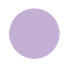

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F10:P:0_6</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAACLqElEQVR4nOzdd3wc1bn/8c/M9lVvlmy5V0wvNiVA6JDQAkkoIVxII6SR5IZLem7q/aV3CAmpJAFCDb13YpptjA3GvVdZktXLtpnfH2dXu9KubMlayUXf9%2Bu1L9mzq9mZ1ezMmec85zmW67qIiIiIiIiIiIiIiOSbvbc3QEREREREREREREQOTApAi4iIiIiIiIiIiMiwUABaRERERERERERERIaFAtAiIiIiIiIiIiIiMiwUgBYRERERERERERGRYaEAtIiIiIiIiIiIiIgMCwWgRURERERERERERGRYKAAtIiIiIiIiIiIiIsNCAWgRERERERERERERGRYKQIuIiIiIiIiIiIjIsPDu7Q1IqaysdCdPnry3N0NEREREREREREREdmHhwoUNrutWDeS1%2B0wAevLkySxYsGBvb4aIiIiIiIiIiIiI7IJlWRsG%2BlqV4BARERERERERERGRYaEAtIiIiIiIiIiIiIgMCwWgRURERERERERERGRYKAAtIiIiIiIiIiIiIsNiUAFoy7ImW5a1yLKs9ZZl/X5Xyy3L%2BqxlWZsty9pgWdb7873hIiIiIiIiIiIiIrJvG2wG9GeA54GZwOWWZc3axfKrga8AfwYuzcfGioiIiIiIiIiIiMj%2BwzvI11cBa1zXjVqW1QxUAiv6WX4HJvjsA3JmQFuW9UngkwATJ07ck%2B0XERERERERERERkX3UYDOgG4AxlmV5gRKgbhfLvwacA1yDyYTO4rruLa7rznFdd05VVdWebL%2BIiIiIiIiIiIiI7KMGmwF9M3AvJuv5NuALlmX9pe9y13VXW5Z1S/I1DvB/%2BdtkEREREREREREREdkfDCoA7bruWuCofp4%2Bqs9rvwl8cw%2B3S0RERERERERERET2c4MtwSEiIiIiIiIiIiIiMiAKQIuIiIiIiIiIiIjIsFAAWkRERERERERERESGhQLQIiIiIiIiIiIiIjIsFIAWERERERERERERkWGhALSIiIiIiIiIiIiIDAsFoEVERERERERERERkWCgALSIiIiIiIiIiIiLDQgFoERERERERERERERkWCkCLiIiIiIiIiIiIyLBQAFpEREREREREREREhoUC0CIiIiIiIiIiIiIyLBSAFhEREREREREREZFhoQC0iIiIiIiIiIiIiAwLBaBFREREREREREREZFgoAC0iIiIiIiIiIiIiw0IBaBEREREREREREREZFgpAi4iIiIiIiIiIiMiwUABaRERERERERERERIaFAtAiIiIiIiIiIiIiMiwUgBYRERERERERERGRYeHd2xuwX3ES0LwYGl6FRCeExsGYUyBcu7e3TERERERERERERGSfowD0QLgOrL8d3vgiJKLgxsGJgycATgwqjoW5N0PpIXt7S0VERERERERERET2GQpA707bGnjhQujYAImO3s/FY%2BZn/Tx4Yg5Mvgrm/g5sz8hvp4iIiIiIiIiIiMg%2BRgHoXencAk%2BdCN31gLOLFzqQ6Ib1/zSlOU74O1jWSG2liIiIiIiIiIiIyD5JkxD2J9IIT51kfu4y%2BJwh0Qmb7oM3rh/WTRMRERERERERERHZHygAnUusHZ4%2BFbq2mnrPg5HohNV/gLf/b1g2TURERERERERERGR/oQB0Lgs/D22rwInu2e8nOmHp/4P6l/O7XSIiIiIiIiIiIiL7EQWg%2B2paAhv%2BBU5kaOtJdMJrH8/PNomIiIiIiIiIiIjshxSAzuS68PonzISC%2BdCxKT/rEREREREREREREdkPKQCdafP90PwO4OZnfYmO/KxHREREREREREREZD%2BkAHRKohvmf1pBYxEREREREREREZE8UQA6Zd0/Ida%2Bt7dCRERERERERERE5IChADSY2s/LfqLsZxEREREREREREZE8UgAaoHE%2BdG7d21shIiIiIiIiIiIickDx7u0N2Ces/A0kunb/Om8hHPTfMPFS8BZA5xZ454ew9dHh30YRERERERERERGR/YwC0Ilu2PRvwNn166Z9HI76OdheE3wGKJwCZXdC%2BxqY9yFoXTbsmysiIiIiIiIiIiKyv1AJjq2PguXZ9WumfwqO%2BTX4S9LB5xRfIZQeBmf9BwqmDN92ioiIiIiIiIiIiOxnFIBe/UeIt/X//MRL4OifZweeM1k2%2BErg7HkQrMn/NoqIiIiIiIiIiIjsh0Z3ANp1YMeL/T9fMBmO/yt4w7tfl%2B2BQCWcfG/eNk9ERERERERERERkfza6A9BNi032cn/m3gSWf%2BDrs31QejjUXjD0bRMRERERERERERHZz43uAPT2Z8CJ5X5uzCnm4fENbp2%2BQjj2D2APInAtIiIiIiIiIiIicgAa3QHoLQ%2BCE8n93LG37Lru8674imDW5/d8u0REREREREREREQOAIMKQFuWNdmyrEWWZa23LOv3u1puWVatZVkPWJb1jmUNpo7FCHHi0Dg/93NjToXQ2D1ft7cQZn951%2BU9RERERERERERERA5wg42QfgZ4HpgJXG5Z1qxdLP8rcBjgAU7Px8bm1c6FpmZzLrOvB88eZj%2BneAIw9r1DW4eIiIiIiIiIiIjIfmywAegqoNF13SjQDFTuYvkpwOXAr4Hv5VqZZVmftCxrgWVZC%2Brr6we/9UOx/enc5Td8pVBzJthDzF72FcPMzw1tHSIiIiIiIiIiIiL7scFGWRuAMZZleYESoG4Xy5sBP9AF5Cy07LruLa7rznFdd05VVdUebP4Q7HgenGj28okfNOU58qH61PysR0RERERERERERGQ/5B3k628G7gVWALcBX7As6y99l7uuu9qyrC8Cf8MEnz%2Bdrw3Om5bluZdP/Qj4CvPzHk4UPMH8rEtERERERERERERkPzOoALTrumuBo/p5%2Bqg%2Br70DuGMPt2t4OTHo3p693PZB%2BTH5ex9fcf7WJSIiIiIiIiIiIrKfGWKh4/1U%2B9rcmcnlcyGRs1qIiIiIiIiIiIiIiAzS6AxAtywDK8eu15wBntDIb4%2BIiIiIiIiIiIjIAWh0BqBbl0G8M3v5%2BAvB4x/57RERERERERERERE5AI3OAPTOBeDGey%2BzPFBy%2BN7ZHhEREREREREREZED0OgMQDe/nb2sYDI40RHfFBEREREREREREZED1egMQHdtzV5WMjs7K1pERERERERERERE9tjoC0C7Tu76z8WzwRMe%2Be0REREREREREREROUCNvgB0tBlsX/by8qM1AaGIiIiIiIiIiIhIHo2%2BAHSkIXcAulQTEIqIiIiIiIiIiIjk0%2BgMQFue7OWh2pHfFhEREREREREREZED2CgMQDcCbvZyX%2BGIb4qIiIiIiIiIiIjIgWwUBqAbwE30XuYrASe%2Bd7ZHRERERERERERE5AA1OgPQiUjvZYEKcKJ7Z3tEREREREREREREDlCjLwDdvQPcPtnOgcrsrGgRERERERERERERGZLRF4CONWcvC1SO%2BGaIi

<h3>Cluster 10 (8 motifs)</h3>

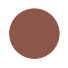

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>STFT:T2:C:0_2</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAADVaElEQVR4nOzddZhc5dnH8e8ZWd/4xp0IIQQNECBocJfiWgqUQoEiBdpSo6UFSqHIi2uxYiFICCFIIFgcSELcfZN1HT3vH89MdpOVObM7szOb/D7XNdfuzpw551k7cp/7uW/Ltm1ERERERERERERERBLNleoBiIiIiIiIiIiIiMjOSQFoEREREREREREREUkKBaBFREREREREREREJCkUgBYRERERERERERGRpFAAWkRERERERERERESSQgFoEREREREREREREUkKBaBFREREREREREREJCkUgBYRERERERERERGRpFAAWkRERERERERERESSQgFoEREREREREREREUkKBaBFREREREREREREJCk8rV2BZVkDgXeAzsBHtm1f09TzlmU9CvwMKAUm27Z9Y3Pr7tatmz1w4MDWDlFEREREREREREREEmT27NlbbdsucLJsqwPQwLXAVOB2oNCyrAdt217c2PPA7kAZYAPvx1rxwIEDmTVrVgKGKCIiIiIiIiIiIiKJYFnWaqfLJqIERwFQZNu2H5PZ3K2Z568FDgHuB%2B5qbGWWZV1tWdYsy7JmbdmyJQHDExEREREREREREZFUSEQAeivQ3bIsD9AR2NzM8zcCA4AQ4G9sZbZtP2Xb9mjbtkcXFDjK4hYRERERERERERGRNJSIEhyPA28Di4FXgBsty3pux%2Bdt215mWdY3wJtANfCrBGxbRERERERERERERNJUqwPQtm2vAPZt4uV9d1j2FUyQWkRERERERERERER2cokowSEiIiIiIiIiIiIi0oAC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFApAi4iIiIiIiIiIiEhSKAAtIiIiIiIiIiIiIkmhALSIiIiIiIiIiIiIJIUC0CIiIiIiIiIiIiKSFJ5UD0BEREREpDmhEFRVQW0tZGRAXh54dBYrIiIiItIu6NRdRERERNJKIABTp8IXX8DkyTBvHoTD4Habj%2BEwDB0Kxx4LRx0F48ZBfn6qRy0iIiIiIo1RAFpERERE0kJVFTz1FPzjH%2BD3Q3U1BIN1rwcCdZ8vXAiLF8MLL5gM6WuvhVtvhe7d23zYIiIiIiLSDNWAFhEREZGUCgbh7ruhZ0/44x9h61YoL98%2B%2BNyYcNgsV1UFjzwCAwbA1VdDRUXbjFtERERERGJTAFpEREREUmbVKjjgAJP1XFlpgsktUVtrHi%2B9BMOHw/TpCR2miIiIiIi0kALQIiIiIpISL78Me%2B5pajxXVydmnbW1sHGjqQ395z%2Bb8hwiIiIiIpI6CkCLiIiISJuybbjzTvjlL03GczKCxDU1cP/9cOaZ29eOFhERERGRtqUAtIiIiIi0GduG3/4WHnwwcVnPTamuhk8/hVNOAZ8vudsSEREREZHGtToAbVnWQMuy5lqWtcqyrCccPD/Csqxqy7Iubu22RURERKT9sG349a/h8ceTH3yOqq6GadPghBNMeQ4REREREWlbiciAvhaYCgwDzrcsa3hTz1uWlQE8CxQmYLsiIiIi0o78/vfwwgttF3yOqqkxTQnPOAPC4bbdtoiIiIjIri4RAegCoMi2bT9QCnRr5vl7gJeAVU2tzLKsqy3LmmVZ1qwtW7YkYHgiIiIikmoTJsDDD7d98Dmqpga%2B%2Bgr%2B8pfUbF9EREREZFeViAD0VqC7ZVkeoCOwuYnng8DFwI3AgcB9ja3Mtu2nbNsebdv26IKCggQMT0RERERSaeFCuPji1AWfo6qqTGPCDz5I7ThERERERHYliQhAPw4cBiwGXgFutCxr3x2ft217um3b3W3b3h2YAdyWgG2LiIiISBorK4Pjjkt98DmqpgYuuAAWL071SEREREREdg2e1q7Atu0VwL5NvNzo87ZtH9na7YqIiIhI%2BrviCtiyxTQgTBdVVXDqqbBkSapHIiIiIiKy80tEBrSIiIiISAOTJsFHH4HPl%2BqRbM%2B2Yf36VI9CRERERGTXoAC0iIiIiCRcZSVcdln6lN7YUbqOS0RERERkZ6MAtIiIiIgk3G9/CxUVqR6FiIiIiIikmgLQIiIiIpJQM2bAiy9CbW2qRyIiIiIiIqnW6iaEIiIiIiJRtg3XXAM1NakeiYi0SqACKpZCsBqwwZ0NuQMhq1uqRyYiIiLtjALQIiIiIpIwH38MS5akehQiErdgFax%2BAzZ8CEXToWYTeLIBq26ZUA14O0KX/aHncTDoIsjqnrIhi4iISPtg2bad6jE0afTo0fasWbNSPQwRERERccC2YY89YNGiVI/EmTQ%2BDRZpO%2BWLYdGDsPIlsFwQrHT2PncW2EDvE2DErdDtELCsmG8TERGRnYNlWbNt2x7tZFllQIuIiIhIQkyYAOvWpXoUIuKIrwhm/hrWvwvhANjB%2BN4fihR5X/cubJoCHUfBIS9B/pDEj1VERETaNTUhFBEREZFWC4Xgppug0mHypIikiG3Dylfgvd1g3TumrEa8weftV2jKdxTPhA/3gnl/MwFtERERkQgFoEVERESk1SZMgKKiVI9CRJoVrIKpJ8HMX0KgDMK%2BxK3bDplg9k/3wMRRUK3pECIiImIoAC0iIiIirXbXXcp%2BFklrNRvho9FQONUEopMlVA2Vy%2BDDvaF4bvK2IyIiIu2GAtAiIiIi0iozZ8KyZakehYg0qXSeKY9RsayudnMy2SHwF8OUw2D9B8nfnoiIiKQ1NSEUERERkVa55x6oTUJMy%2BuF/faDsWPh4IMhPx9qauD77%2BHLL2H6dKhKYiKnyE6hdD58fCgEK9p%2B26Eq%2BOo8OPRV6Ht6229fRERE0oJl23aqx9Ck0aNH27NmzUr1MERERESkCVu3Qr9%2BiQ1Ad%2BwI118Pt95qvs7MhKysutf9fqiuhowMeP55EwBf14Jys2l8GiySGFVrYNJ%2BJhuZFP7Bu3Pg6I%2Bh4NDUjUFEREQSyrKs2bZtj3ayrEpwiIiIiEiLPfMMWFbi1nf55SaY/LvfmUB0x47bB5/BBJ47dYKcHLjySliyBO6%2BG9zuxI1DpN3zRUpgBEpJafAZTF3oz0%2BE0gWpHYeIiIikhALQIiIiItIitg2PPmrKYrRWx47w3nvwyCOQl2eCy05kZkJ2NtxwA8yZA4MGtX4sIu1eyA%

<h3>Cluster 11 (1 motifs)</h3>

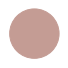

<table><colgroup><col style="width: 10%"></col><col style="width: 90%"></col></colgroup><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">Motif</th></tr></thead><tbody><tr><td>ST:T2:F1:P:0_3</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOyddZgcVdbG32oZt2RmMnF3d4NAIEJwd2cXdrFlcVgWWXZZFmcXW1w%2BnOCSkECEuLsnE5uZjLu31PfH6d6Z6brVXdV9q2eSnN/zzANpqarurrp173vOeY%2BiqioYhmEYhmEYhmEYhmEYhmEYRja21j4AhmEYhmEYhmEYhmEYhmEY5tiEBWiGYRiGYRiGYRiGYRiGYRjGEliAZhiGYRiGYRiGYRiGYRiGYSyBBWiGYRiGYRiGYRiGYRiGYRjGEliAZhiGYRiGYRiGYRiGYRiGYSyBBWiGYRiGYRiGYRiGYRiGYRjGEliAZhiGYRiGYRiGYRiGYRiGYSyBBWiGYRiGYRiGYRiGYRiGYRjGEliAZhiGYRiGYRiGYRiGYRiGYSyBBWiGYRiGYRiGYRiGYRiGYRjGEhytfQBmyMjIUHv27Nnah8EwDMMwDMMwDMMwDMMwDHPcsm7dumJVVTONvPaoEqB79uyJtWvXtvZhMAzDMAzDMAzDMAzDMAzDHLcoinLQ6GvZgoNhGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEtgAZphGIZhGIZhGIZhGIZhGIaxBBagGYZhGIZhGIZhGIZhGIZhGEuIWIBWFKWnoigbFEU5oCjKf4M9rijKDEVRPlYUZbbv3w5FUb7xveY3RVFSIz0ehmEYhmEYhmEYhmEYhmEYpm0gIwP6FgCLAPQHcJmiKAOCPJ4M4DCANN9rZgLoDqAXgGoAl0k4HoZhGIZhGIZhGIZhGIZhGKYNIEOAzgRQoqpqI4ByABl6j6uq%2BhWAHQHvLVVVVQVQ2Oy9/0NRlJsURVmrKMraoqIiCYfLMAzDMAzDMAzDMAzDMAzDRAMZAnQxgA6KojgApAIoCPF44Hszff%2BfIXqNqqpvqKo6VlXVsZmZmYFPMwzDMAzDMEzr46oEilcBpRsAr7u1j4ZhGIZhGIZh2gwyBOjXAEwBsAvARwDuUBRlVODjqqruFbx3HoCDiqLsBZAE4DMJx8MwDMMwDMMw0aG%2BGFh5A/BVR2DhacAvJwNfdQK2PwOo3tY%2BOoZhGIZhGIZpdRRyvzg6GDt2rLp27drWPgyGYRiGYRiGASp2Ar%2BeCjQUA6qr5XP2BCDzROCkrwBHYuscH8MwDMMwDMNYhKIo61RVHWvktTIyoBmGYRiGYRjm%2BKLmMDBvElCfrxWfAcBTCxT%2BBiyYAXg90T8%2BhmEYhmEYhmkjsADNMAzDMAzDMGbwNAKLzgDcVQCCVBN664GyTcCmv0Tt0BiGYRiGYRimrcECNMMwDMMwDMOYYfPDQHU2oBrIbPbUArtfBgqXWn9cDMMwDMMwDNMGYQGaYRiGYRiGYYxSmwvsfomEZaN4aoG1twBHUe8VhmEYhmEYhpEFC9AMwzAMwzAMY5SND4bn6VydDeR8K/94GIZhGIZhGKaNwwI0wzAMwzAMwxihYgdweDagNpp/r7sGWPcnwOuWf1wMwzAMwzAM04ZhAZphGIZhGIZhjLD%2BTsDbEP77G0uB7PekHQ7DMAzDMAzDHA2wAM0wDMMwDMMwoagvBAoWAao3/G24a4CdL0g7JIZhGIZhGIY5GmABmmEYhmEYhmFCcfBzQLFHvp2a7Mi3wTAMwzAMwzBHESxAMwzDMAzDMEwo9r4OeGoj346qRr4NhmEYhmEYhjmKYAGaYRiGYRiGYYJRvR%2Bo2itnW5F4SDMMwzAMwzDMUQgL0AzDMAzDMAwTjAMfAeDMZYZhGIZhGIYJBxagGYZhGIZhGCYY%2B97izGWGYRiGYRiGCRMWoBmGYRiGYRhGj/ItQH1Rax8FwzAMwzAMwxy1sADNMAzDMAzDMHpkfwB4Xa19FAzDMAzDMAxz1MICNMMwDMMwDMPokfMNoLIAzTAMwzAMwzDhwgI0wzAMwzAMw4hoLANqD7X2UTAMwzAMwzDMUQ0L0AzDMAzDMAwjonAJYI9r7aNgGIZhGIZhmKMaFqAZhmEYhmEYRsSReYCrurWPgmEYhmEYhmGOaliAZhiGYRiGYRgRR%2BYC8Bp/vS0GUOyWHQ7DMAzDMAzDHI2wAM0wDMMwDMMwgbiqjfs/txsNzFwBXFJDf5M/BGLaWXt8DMMwDMMwDHOUwAI0wzAMwzAMwwRSuhawJ4R%2BXcfpwIzfgIyJgM0B2GOBbhcBs9YC8Z2tP04r8TQCJWuAomVAfXFrHw3DMAzDMAxzlOJo7QNgGIZhGIZhmDZH8QrAXRv8Ne1GASd9AzgSWz5ujwXiuwGnrQK%2B7wd46i07TEtw1wAbHgD2vwfABigKfYbME4CxLwGpg1v7CBmGYRiGYZijCM6AZhiGYRiGYZhAjswDVFfw10x4C7DFi5%2BzOwFnGjDwbumHZikV24EfBgP73gLc1YC7EnBVAN4GoGAhMHccsO%2Bd1j5KhmEYhmEY5iiCBWiGYRiGYRiGaY6qAqXrgr%2Bm2wVAcn/AFmQ67UwChjwIxHWQe3xWUb0fmHciUHsY8IqytlXAUwusvR3Ifi/aR8cwDMMwDMMcpUQsQCuK0lNRlA2KohxQFOW/wR5XFOV6RVEOKYqyR1GUWYqixCmKMldRlBxFUVYpipIR6fEwDMMwDMMwTETU5QKqW/95Wwww9hUSmEOhOIBRz8g7NqtoLAd%2BORlwVwBQg7/WUwusuQXIXxCNI2MYhmEYhmGOcmRkQN8CYBGA/gAuUxRlQJDHnwJwNoCHADwKoDeAKQD6AkgHMFbC8TAMwzAMwzBM%2BFTuJJFZj17XAA4D4jPga0p4MZDYQ86xWcW6O4H6QkD1Gnu9pw5Ydhn5RTMMwzAMwzBMEGQI0JkASlRVbQRQDiAjyOOZAEoAFPr%2BvRvATt9jMQCWBW5cUZSbFEVZqyjK2qKiIgmHyzAMwzAMwzBBqNgJeBr0n%2B93i7Hs5%2Bb0uCKyY7KSohXAoc/I59kM7mpg44PWHBPDMAzDMAxzzCBDgC4G0EFRFA

In [23]:
# Show some examples of motifs in each cluster, from highest to lowest reproducibility
num_examples_to_show = 5
cmap = cm.get_cmap("tab20")
rng = np.random.RandomState(seed)

for cluster_id in np.unique(reordered_cluster_ids):
    match_inds = np.where(reordered_cluster_ids == cluster_id)[0]
    display(vdomh.h3("Cluster %d (%d motifs)" % (cluster_id, len(match_inds))))
    
    group_color = matplotlib.colors.rgb2hex(cmap(cluster_id % 20 / 20))
    fig, ax = plt.subplots(figsize=(1, 1))
    circle = plt.Circle((0, 0), 10, color=group_color)
    ax.add_patch(circle)
    ax.axis("off")
    plt.axis("scaled")
    plt.show()
    
    colgroup = vdomh.colgroup(
        vdomh.col(style={"width": "10%"}),
        vdomh.col(style={"width": "90%"})
    )
    header = vdomh.thead(vdomh.tr(
        vdomh.th("Motif ID", style={"text-align": "center"}),
        vdomh.th("Motif", style={"text-align": "center"})
    ))

    rows = []
    inds_to_show = rng.choice(match_inds, size=min(num_examples_to_show, len(match_inds)), replace=False)
    for i in inds_to_show:
        fig = viz_sequence.plot_weights(
            sorted_motifs[i], subticks_frequency=100, figsize=(20, 4), return_fig=True
        )
        fig.tight_layout()
        plt.savefig(
            os.path.join(out_path, "%s_cluster_%d_motif_%s.svg" % (tf_name, cluster_id, sorted_motif_keys[i])),
            format="svg"
        )
        rows.append(vdomh.tr(
            vdomh.td(sorted_motif_keys[i]),
            vdomh.td(figure_to_vdom_image(fig))
        ))
    display(vdomh.table(colgroup, header, vdomh.tbody(*rows)))
    plt.close("all")